In [6]:
import json
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModelForSeq2SeqLM
from scipy.special import softmax
from tqdm import tqdm

# Configurar dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Cargar JSON original agrupado por político
with open("Spain_Completo.json", "r", encoding="utf-8") as f:
    data = json.load(f)

# Modelos alternativos
MODELS = {
    "sentiment": "finiteautomata/beto-sentiment-analysis",
    "hate": "pysentimiento/robertuito-hate-speech"
}

labels_map = {
    "sentiment": ["negative", "neutral", "positive"],
    "hate": ["none", "offensive", "hate"]
}

# Cargar clasificadores
models = {}
tokenizers = {}
for task, model_name in MODELS.items():
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name).to(device)
    model.eval()
    tokenizers[task] = tokenizer
    models[task] = model

# Cargar modelo generativo de emoción
emotion_model_name = "mrm8488/t5-base-finetuned-emotion"
emotion_tokenizer = AutoTokenizer.from_pretrained(emotion_model_name)
emotion_model = AutoModelForSeq2SeqLM.from_pretrained(emotion_model_name).to(device)
emotion_model.eval()

# Función para clasificador
def analyze(text, tokenizer, model):
    inputs = tokenizer(text, return_tensors="pt", truncation=True).to(device)
    with torch.no_grad():
        logits = model(**inputs).logits[0].cpu().numpy()
    return softmax(logits)

# Función para modelo T5
def predict_emotion_t5(text):
    input_text = f"emotion: {text}"
    input_ids = emotion_tokenizer.encode(input_text, return_tensors="pt", truncation=True).to(device)
    with torch.no_grad():
        output_ids = emotion_model.generate(input_ids, max_length=2)
    emotion = emotion_tokenizer.decode(output_ids[0], skip_special_tokens=True)
    return emotion

# Procesar tweets y replies dentro de la misma estructura
for persona in tqdm(data):
    for tweet in persona["tweets"]:
        text = tweet["tweet"]

        for task in MODELS:
            scores = analyze(text, tokenizers[task], models[task])
            tweet[f"{task}_alt_label"] = labels_map[task][scores.argmax()]
            tweet[f"{task}_alt_score"] = float(scores.max())

        tweet["emotion_t5_label"] = predict_emotion_t5(text)

        for reply in tweet.get("replies", []):
            reply_text = reply["reply"]
            for task in MODELS:
                scores = analyze(reply_text, tokenizers[task], models[task])
                reply[f"{task}_alt_label"] = labels_map[task][scores.argmax()]
                reply[f"{task}_alt_score"] = float(scores.max())
            reply["emotion_t5_label"] = predict_emotion_t5(reply_text)

# Guardar la estructura modificada SIN perder nada
with open("Spain_Completo_analizado.json", "w", encoding="utf-8") as f:
    json.dump(data, f, ensure_ascii=False, indent=2)


100%|██████████| 170/170 [01:10<00:00,  2.40it/s]


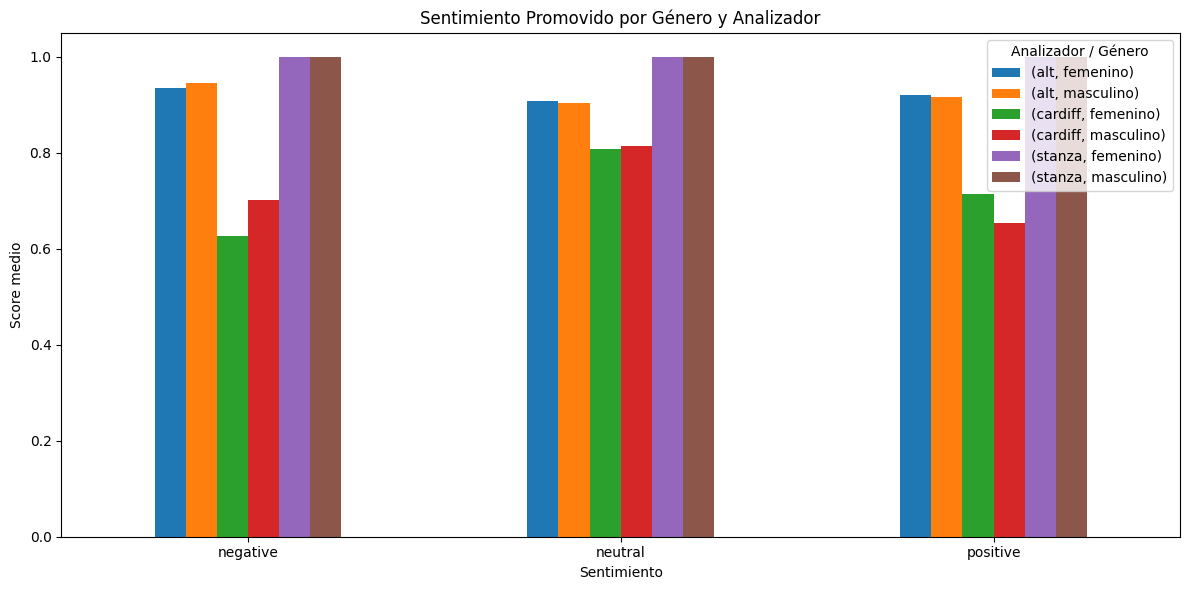

In [25]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import os
# ---------- CONFIGURACIÓN ----------
RUTA_JSON = 'Spain_Completo_analizado.json'  # <- CAMBIA ESTO

CSV_SALIDA = 'resultados_analisis.csv'

def analizar_sentimiento_promovido_por_genero(json_data):
    resultados = defaultdict(lambda: defaultdict(list))

    for politico in json_data:
        genero = politico.get('gender', 'desconocido')

        for tweet in politico.get('tweets', []):
            analysis = tweet.get('analysis', {})

            # Cardiff
            sentiment = analysis.get('sentiment')
            if sentiment:
                label = sentiment.get('label')
                score = sentiment.get('score')
                if label in ['positive', 'neutral', 'negative'] and score is not None:
                    resultados['cardiff'][(genero, label)].append(score)

            # Stanza
            stanza_raw = analysis.get('sentiment_stanza')
            stanza_map = {0: 'negative', 1: 'neutral', 2: 'positive'}
            if stanza_raw in stanza_map:
                label = stanza_map[stanza_raw]
                resultados['stanza'][(genero, label)].append(1.0)

            # Alt
            label = tweet.get('sentiment_alt_label')
            score = tweet.get('sentiment_alt_score')
            if label in ['positive', 'neutral', 'negative'] and score is not None:
                resultados['beto'][(genero, label)].append(score)

    # Convertir a DataFrame
    filas = []
    for analizador, datos in resultados.items():
        for (genero, label), scores in datos.items():
            media = sum(scores) / len(scores) if scores else 0
            filas.append({
                'analizador': analizador,
                'grupo': genero,
                'clase': label,
                'score_medio': media,
                'tipo_analisis': 'promovido',
                'categoria': 'sentimiento'
            })

    return pd.DataFrame(filas)

# ---------- CARGA JSON ----------
with open(RUTA_JSON, 'r', encoding='utf-8') as f:
    data = json.load(f)

# ---------- ANALIZAR Y GUARDAR ----------
df_resultado = analizar_sentimiento_promovido_por_genero(data)

# Guardar en CSV acumulativo
existe = os.path.exists(CSV_SALIDA)
df_resultado.to_csv(CSV_SALIDA, mode='a', index=False, header=not existe)

# ---------- GRAFICAR ----------
pivot = df_resultado.pivot_table(index='clase', columns=['analizador', 'grupo'], values='score_medio')
pivot.plot(kind='bar', figsize=(12, 6), title="Sentimiento Promovido por Género y Analizador")
plt.ylabel("Score medio")
plt.xlabel("Sentimiento")
plt.xticks(rotation=0)
plt.legend(title="Analizador / Género")
plt.tight_layout()
plt.show()

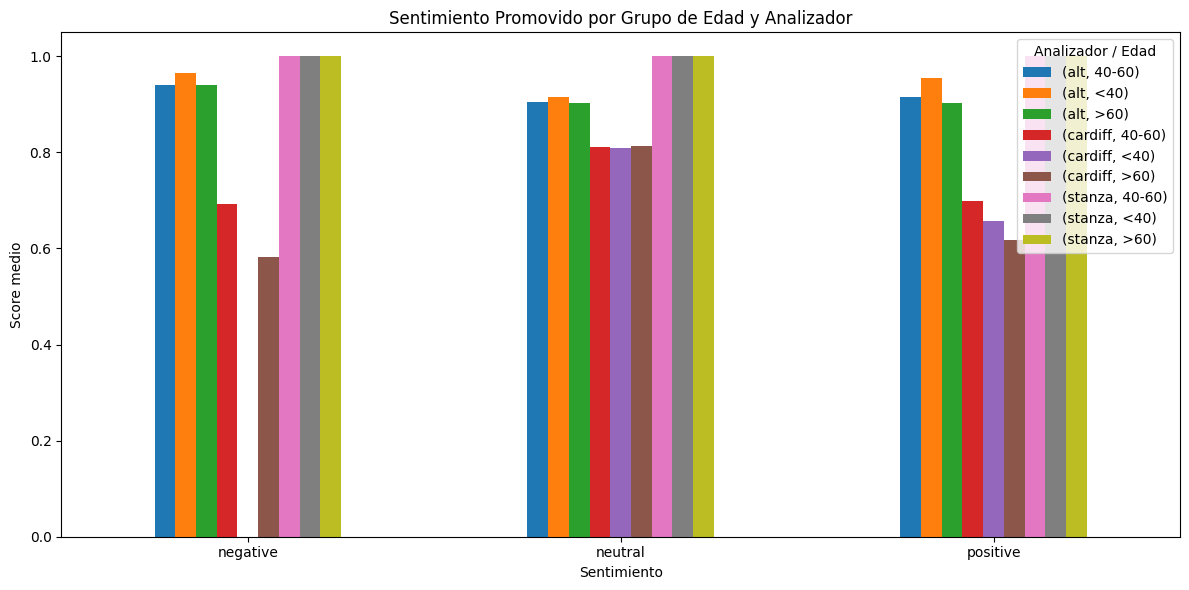

In [26]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import os

# ---------- CONFIGURACIÓN ----------
RUTA_JSON = 'Spain_Completo_analizado.json'  # <- CAMBIA ESTO
CSV_SALIDA = 'resultados_analisis.csv'

def clasificar_edad(age):
    if age is None:
        return 'desconocido'
    try:
        age = int(age)
        if age < 40:
            return '<40'
        elif 40 <= age <= 60:
            return '40-60'
        else:
            return '>60'
    except:
        return 'desconocido'

def analizar_sentimiento_promovido_por_edad(json_data):
    resultados = defaultdict(lambda: defaultdict(list))

    for politico in json_data:
        edad = politico.get('age', None)
        grupo_edad = clasificar_edad(edad)

        for tweet in politico.get('tweets', []):
            analysis = tweet.get('analysis', {})

            # Cardiff
            sentiment = analysis.get('sentiment')
            if sentiment:
                label = sentiment.get('label')
                score = sentiment.get('score')
                if label in ['positive', 'neutral', 'negative'] and score is not None:
                    resultados['cardiff'][(grupo_edad, label)].append(score)

            # Stanza
            stanza_raw = analysis.get('sentiment_stanza')
            stanza_map = {0: 'negative', 1: 'neutral', 2: 'positive'}
            if stanza_raw in stanza_map:
                label = stanza_map[stanza_raw]
                resultados['stanza'][(grupo_edad, label)].append(1.0)

            # Alt
            label = tweet.get('sentiment_alt_label')
            score = tweet.get('sentiment_alt_score')
            if label in ['positive', 'neutral', 'negative'] and score is not None:
                resultados['alt'][(grupo_edad, label)].append(score)

    # Convertir a DataFrame
    filas = []
    for analizador, datos in resultados.items():
        for (grupo, label), scores in datos.items():
            media = sum(scores) / len(scores) if scores else 0
            filas.append({
                'analizador': analizador,
                'grupo': grupo,
                'clase': label,
                'score_medio': media,
                'tipo_analisis': 'promovido',
                'categoria': 'sentimiento'
            })

    return pd.DataFrame(filas)

# ---------- CARGA JSON ----------
with open(RUTA_JSON, 'r', encoding='utf-8') as f:
    data = json.load(f)

# ---------- ANALIZAR Y GUARDAR ----------
df_resultado = analizar_sentimiento_promovido_por_edad(data)

# Guardar en CSV acumulativo
existe = os.path.exists(CSV_SALIDA)
df_resultado.to_csv(CSV_SALIDA, mode='a', index=False, header=not existe)

# ---------- GRAFICAR ----------
pivot = df_resultado.pivot_table(index='clase', columns=['analizador', 'grupo'], values='score_medio')
pivot.plot(kind='bar', figsize=(12, 6), title="Sentimiento Promovido por Grupo de Edad y Analizador")
plt.ylabel("Score medio")
plt.xlabel("Sentimiento")
plt.xticks(rotation=0)
plt.legend(title="Analizador / Edad")
plt.tight_layout()
plt.show()


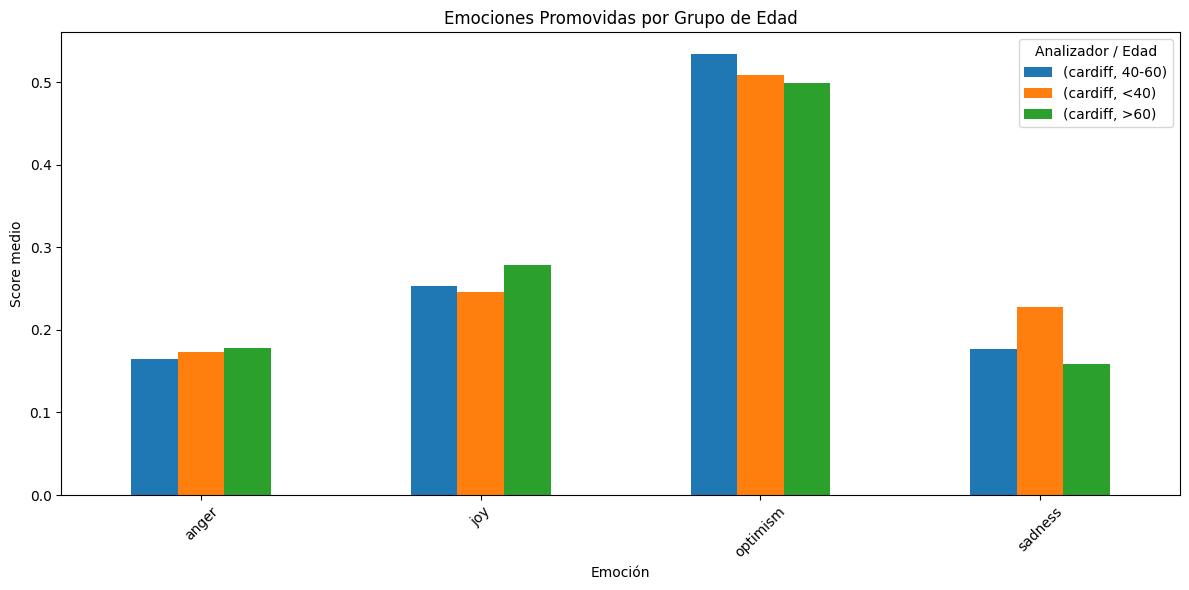

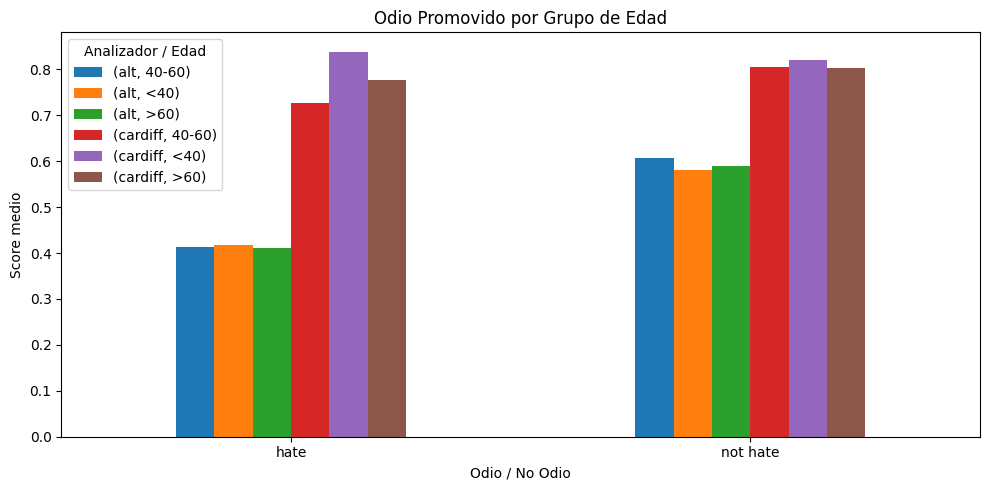

In [28]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import os

# ---------- CONFIGURACIÓN ----------
RUTA_JSON = 'Spain_Completo_analizado.json'  # <- CAMBIA ESTO
CSV_SALIDA = 'resultados_analisis.csv'

def clasificar_edad(age):
    if age is None:
        return 'desconocido'
    try:
        age = int(age)
        if age < 40:
            return '<40'
        elif 40 <= age <= 60:
            return '40-60'
        else:
            return '>60'
    except:
        return 'desconocido'

def analizar_emociones_promovidas_por_edad(json_data):
    resultados = defaultdict(lambda: defaultdict(list))

    for politico in json_data:
        grupo_edad = clasificar_edad(politico.get('age'))

        for tweet in politico.get('tweets', []):
            emociones = tweet.get('analysis', {}).get('emotions', [])
            for emocion in emociones:
                label = emocion.get('label')
                score = emocion.get('score')
                if label and score is not None:
                    resultados['cardiff'][(grupo_edad, label)].append(score)

    # Convertir a DataFrame
    filas = []
    for analizador, datos in resultados.items():
        for (grupo, label), scores in datos.items():
            media = sum(scores) / len(scores) if scores else 0
            filas.append({
                'analizador': analizador,
                'grupo': grupo,
                'clase': label,
                'score_medio': media,
                'tipo_analisis': 'promovido',
                'categoria': 'emocion'
            })

    return pd.DataFrame(filas)

def analizar_odio_promovido_por_edad(json_data):
    resultados = defaultdict(lambda: defaultdict(list))

    for politico in json_data:
        grupo_edad = clasificar_edad(politico.get('age'))

        for tweet in politico.get('tweets', []):
            # Hate principal
            hate = tweet.get('analysis', {}).get('hate', {})
            label = hate.get('label')
            score = hate.get('score')
            if label in ['hate', 'not hate'] and score is not None:
                resultados['cardiff'][(grupo_edad, label)].append(score)

            # Hate alternativo
            label_alt = tweet.get('hate_alt_label')
            score_alt = tweet.get('hate_alt_score')
            if label_alt in ['hate', 'none']:  # asumimos que "none" == "not hate"
                label_alt = 'not hate' if label_alt == 'none' else 'hate'
                if score_alt is not None:
                    resultados['alt'][(grupo_edad, label_alt)].append(score_alt)

    # Convertir a DataFrame
    filas = []
    for analizador, datos in resultados.items():
        for (grupo, label), scores in datos.items():
            media = sum(scores) / len(scores) if scores else 0
            filas.append({
                'analizador': analizador,
                'grupo': grupo,
                'clase': label,
                'score_medio': media,
                'tipo_analisis': 'promovido',
                'categoria': 'odio'
            })

    return pd.DataFrame(filas)

# ---------- CARGA JSON ----------
with open(RUTA_JSON, 'r', encoding='utf-8') as f:
    data = json.load(f)

# ---------- EJECUTAR ANÁLISIS ----------
df_emociones = analizar_emociones_promovidas_por_edad(data)
df_odio = analizar_odio_promovido_por_edad(data)

# ---------- GUARDAR EN CSV ----------
existe = os.path.exists(CSV_SALIDA)
df_emociones.to_csv(CSV_SALIDA, mode='a', index=False, header=not existe)
df_odio.to_csv(CSV_SALIDA, mode='a', index=False, header=False)

# ---------- GRAFICAR EMOCIONES ----------
pivot_emociones = df_emociones.pivot_table(index='clase', columns=['analizador', 'grupo'], values='score_medio')
pivot_emociones.plot(kind='bar', figsize=(12, 6), title="Emociones Promovidas por Grupo de Edad")
plt.ylabel("Score medio")
plt.xlabel("Emoción")
plt.xticks(rotation=45)
plt.legend(title="Analizador / Edad")
plt.tight_layout()
plt.show()

# ---------- GRAFICAR ODIO ----------
pivot_odio = df_odio.pivot_table(index='clase', columns=['analizador', 'grupo'], values='score_medio')
pivot_odio.plot(kind='bar', figsize=(10, 5), title="Odio Promovido por Grupo de Edad")
plt.ylabel("Score medio")
plt.xlabel("Odio / No Odio")
plt.xticks(rotation=0)
plt.legend(title="Analizador / Edad")
plt.tight_layout()
plt.show()


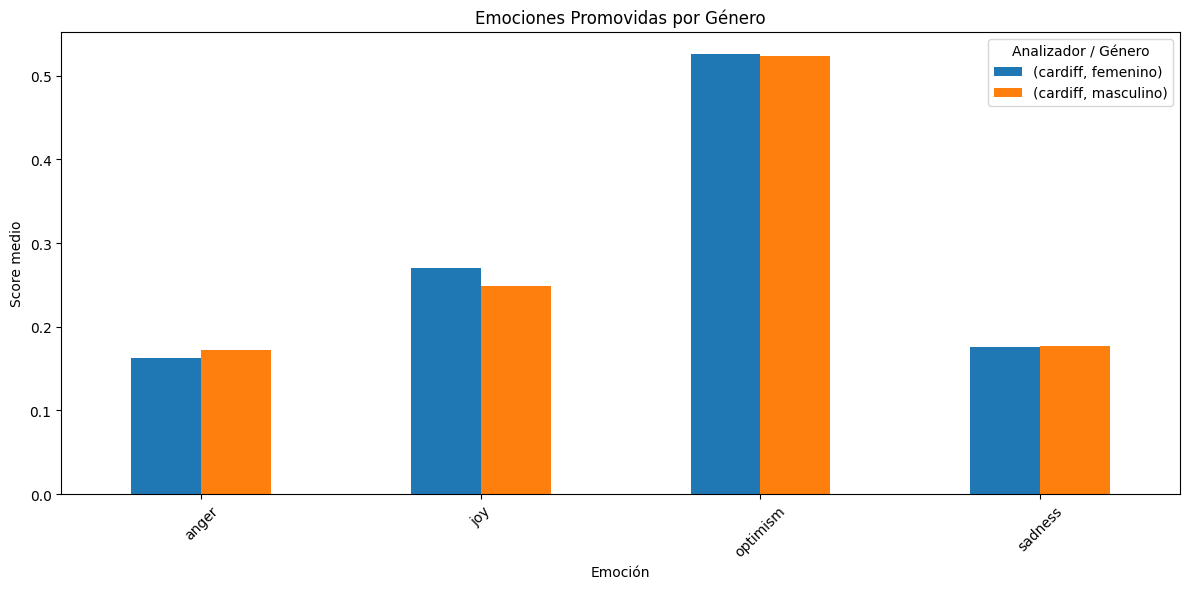

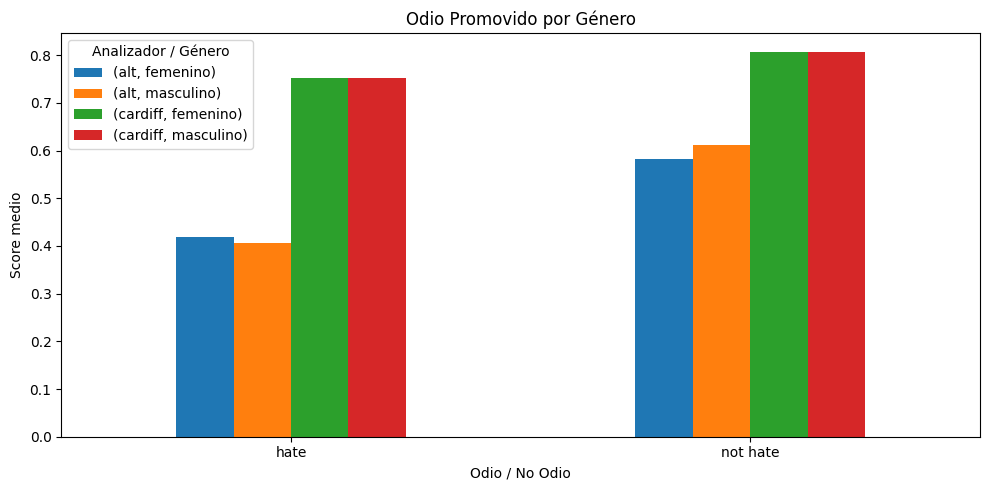

In [29]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import os

# ---------- CONFIGURACIÓN ----------
RUTA_JSON = 'Spain_Completo_analizado.json'  # <- CAMBIA ESTO
CSV_SALIDA = 'resultados_analisis.csv'

def analizar_emociones_promovidas_por_genero(json_data):
    resultados = defaultdict(lambda: defaultdict(list))

    for politico in json_data:
        genero = politico.get('gender', 'desconocido')

        for tweet in politico.get('tweets', []):
            emociones = tweet.get('analysis', {}).get('emotions', [])
            for emocion in emociones:
                label = emocion.get('label')
                score = emocion.get('score')
                if label and score is not None:
                    resultados['cardiff'][(genero, label)].append(score)

    # Convertir a DataFrame
    filas = []
    for analizador, datos in resultados.items():
        for (grupo, label), scores in datos.items():
            media = sum(scores) / len(scores) if scores else 0
            filas.append({
                'analizador': analizador,
                'grupo': grupo,
                'clase': label,
                'score_medio': media,
                'tipo_analisis': 'promovido',
                'categoria': 'emocion'
            })

    return pd.DataFrame(filas)

def analizar_odio_promovido_por_genero(json_data):
    resultados = defaultdict(lambda: defaultdict(list))

    for politico in json_data:
        genero = politico.get('gender', 'desconocido')

        for tweet in politico.get('tweets', []):
            # Hate principal
            hate = tweet.get('analysis', {}).get('hate', {})
            label = hate.get('label')
            score = hate.get('score')
            if label in ['hate', 'not hate'] and score is not None:
                resultados['cardiff'][(genero, label)].append(score)

            # Hate alternativo
            label_alt = tweet.get('hate_alt_label')
            score_alt = tweet.get('hate_alt_score')
            if label_alt in ['hate', 'none']:
                label_alt = 'not hate' if label_alt == 'none' else 'hate'
                if score_alt is not None:
                    resultados['alt'][(genero, label_alt)].append(score_alt)

    # Convertir a DataFrame
    filas = []
    for analizador, datos in resultados.items():
        for (grupo, label), scores in datos.items():
            media = sum(scores) / len(scores) if scores else 0
            filas.append({
                'analizador': analizador,
                'grupo': grupo,
                'clase': label,
                'score_medio': media,
                'tipo_analisis': 'promovido',
                'categoria': 'odio'
            })

    return pd.DataFrame(filas)

# ---------- CARGA JSON ----------
with open(RUTA_JSON, 'r', encoding='utf-8') as f:
    data = json.load(f)

# ---------- EJECUTAR ANÁLISIS ----------
df_emociones = analizar_emociones_promovidas_por_genero(data)
df_odio = analizar_odio_promovido_por_genero(data)

# ---------- GUARDAR EN CSV ----------
existe = os.path.exists(CSV_SALIDA)
df_emociones.to_csv(CSV_SALIDA, mode='a', index=False, header=not existe)
df_odio.to_csv(CSV_SALIDA, mode='a', index=False, header=False)

# ---------- GRAFICAR EMOCIONES ----------
pivot_emociones = df_emociones.pivot_table(index='clase', columns=['analizador', 'grupo'], values='score_medio')
pivot_emociones.plot(kind='bar', figsize=(12, 6), title="Emociones Promovidas por Género")
plt.ylabel("Score medio")
plt.xlabel("Emoción")
plt.xticks(rotation=45)
plt.legend(title="Analizador / Género")
plt.tight_layout()
plt.show()

# ---------- GRAFICAR ODIO ----------
pivot_odio = df_odio.pivot_table(index='clase', columns=['analizador', 'grupo'], values='score_medio')
pivot_odio.plot(kind='bar', figsize=(10, 5), title="Odio Promovido por Género")
plt.ylabel("Score medio")
plt.xlabel("Odio / No Odio")
plt.xticks(rotation=0)
plt.legend(title="Analizador / Género")
plt.tight_layout()
plt.show()


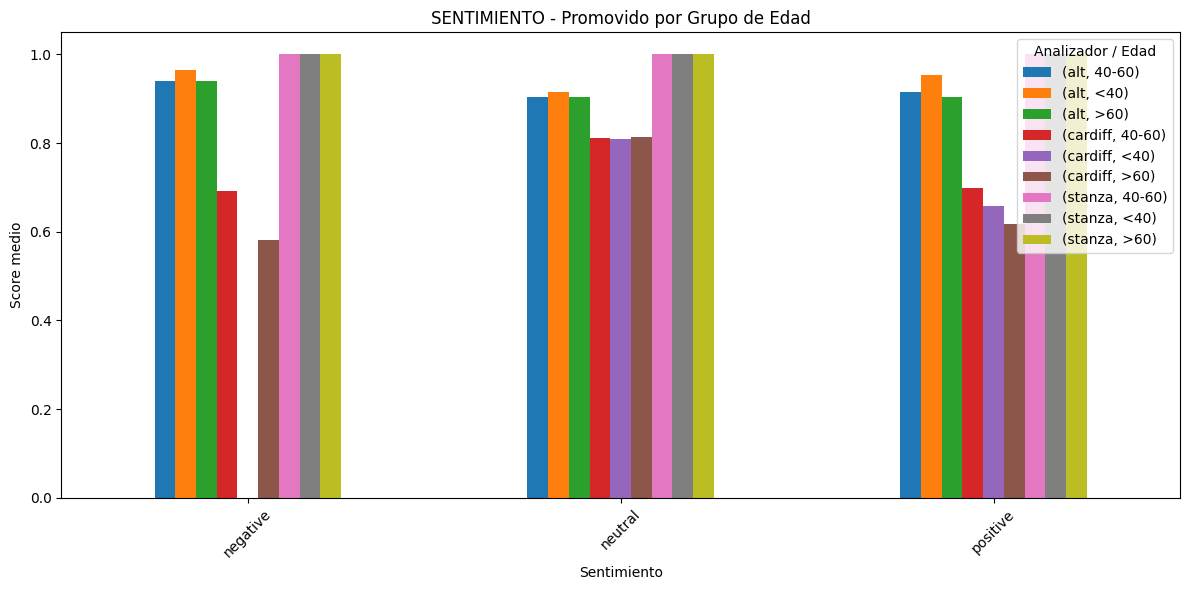

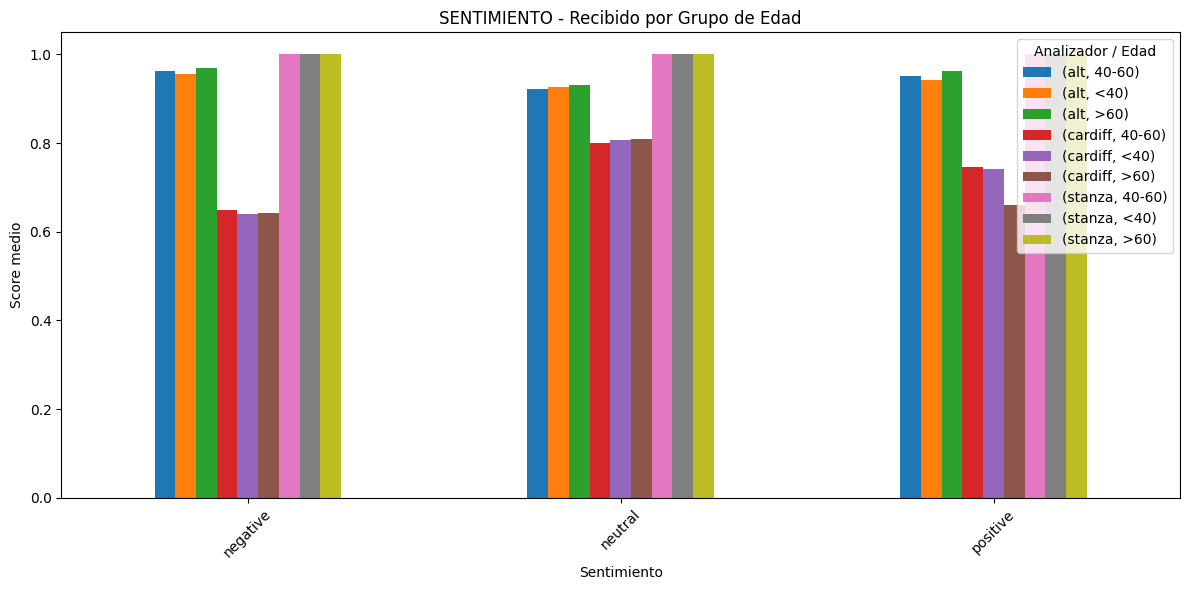

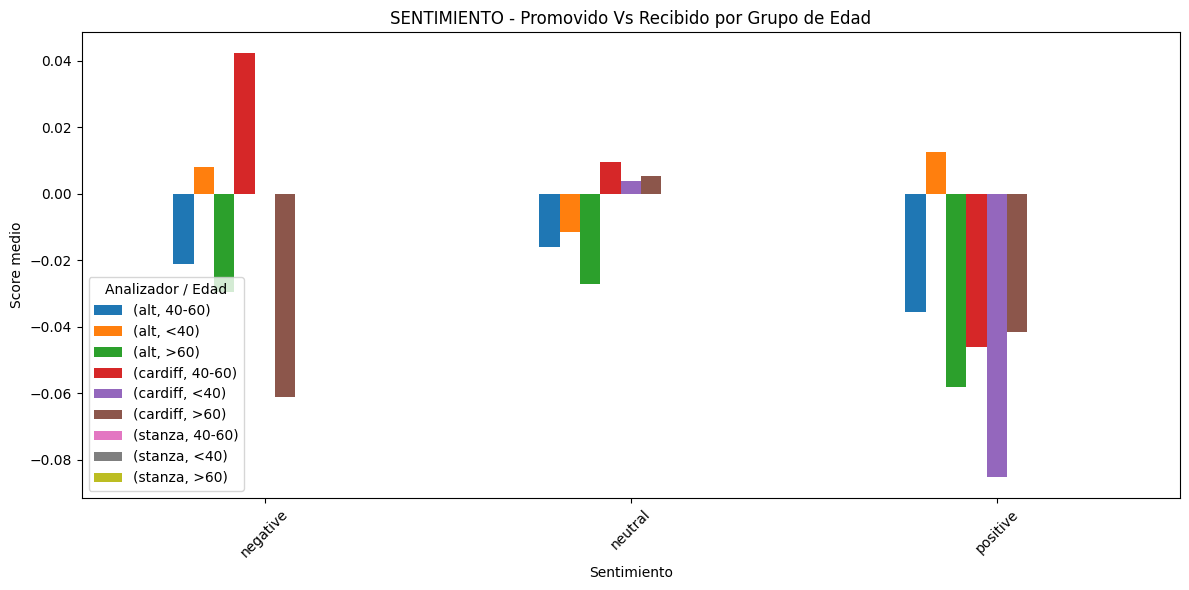

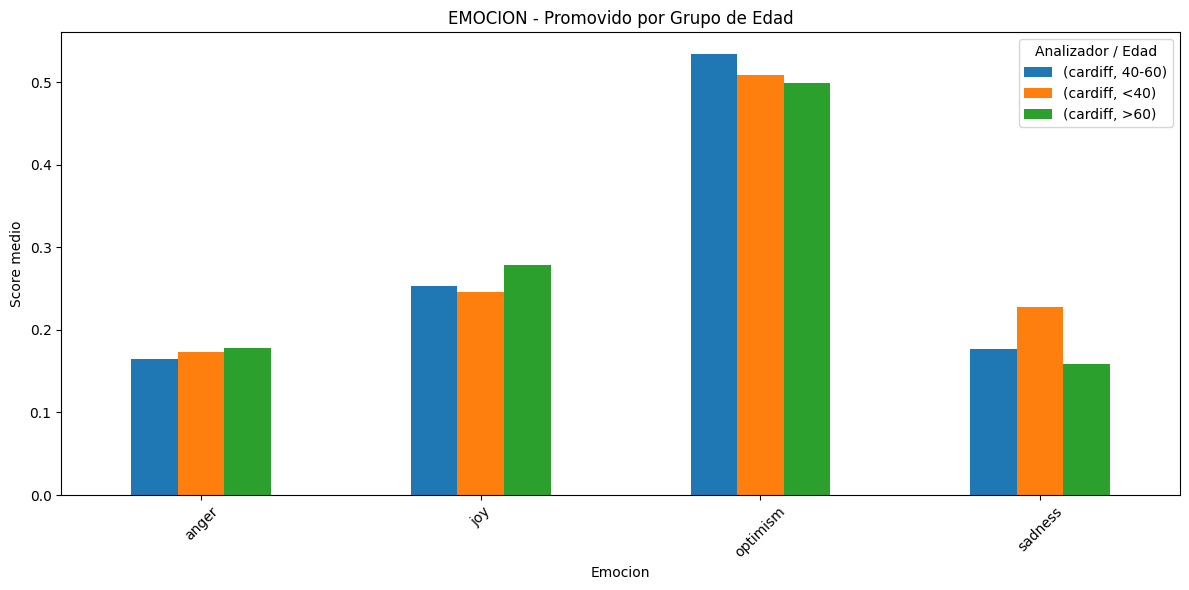

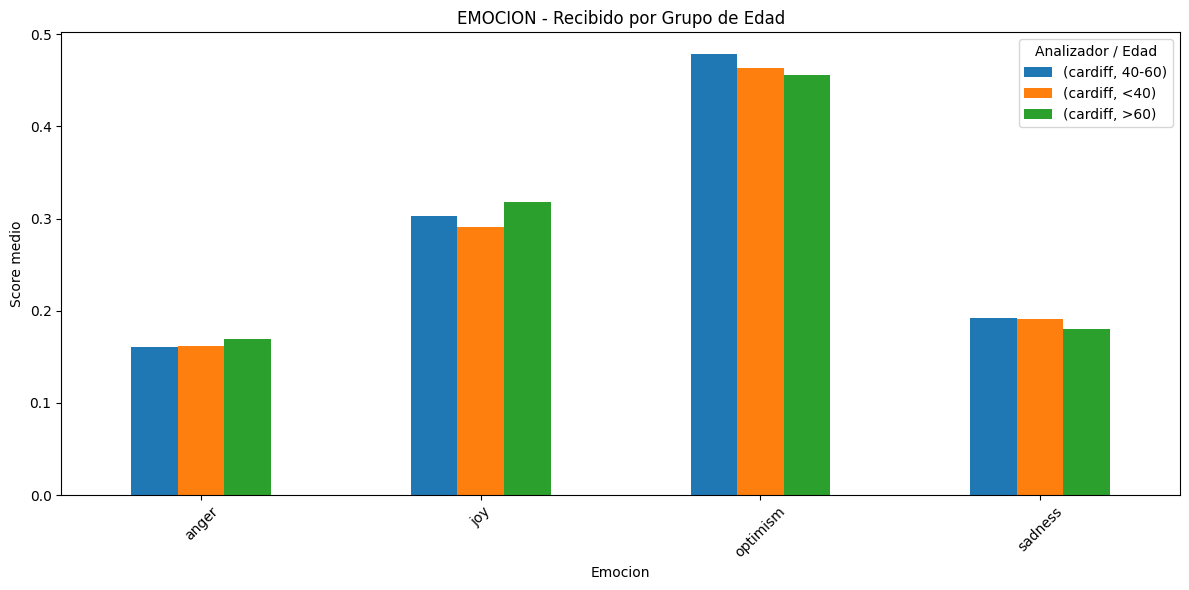

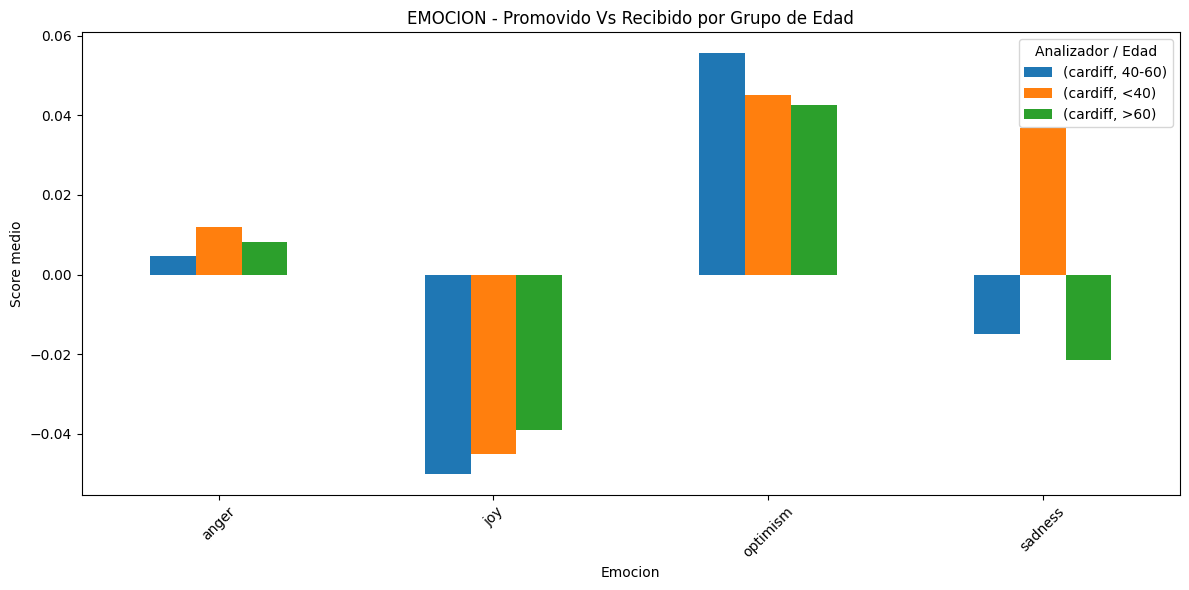

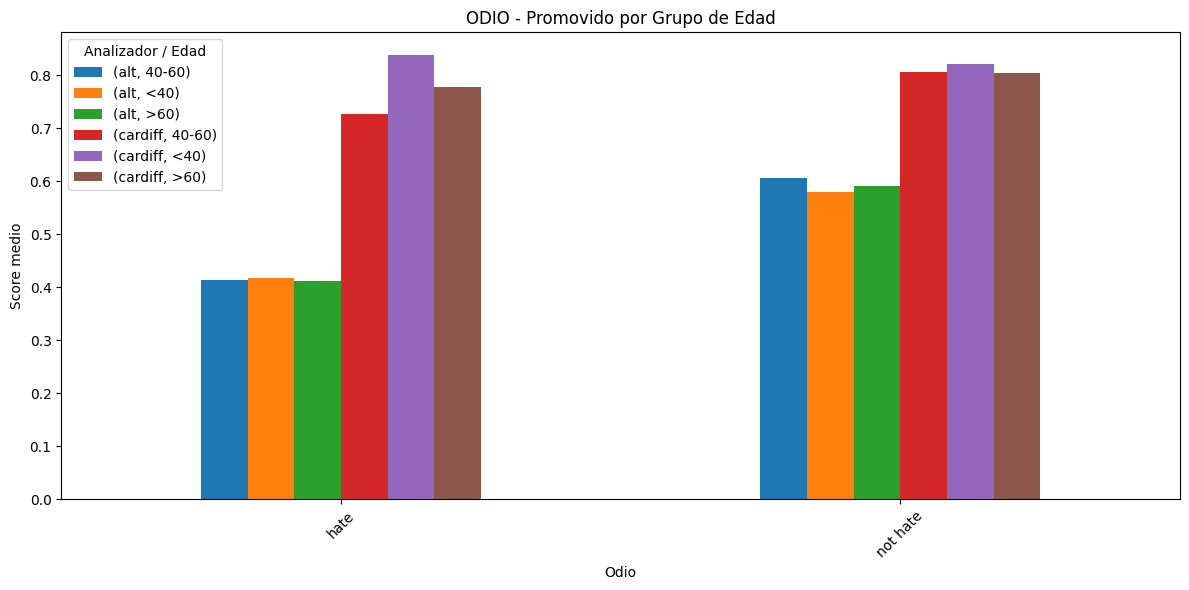

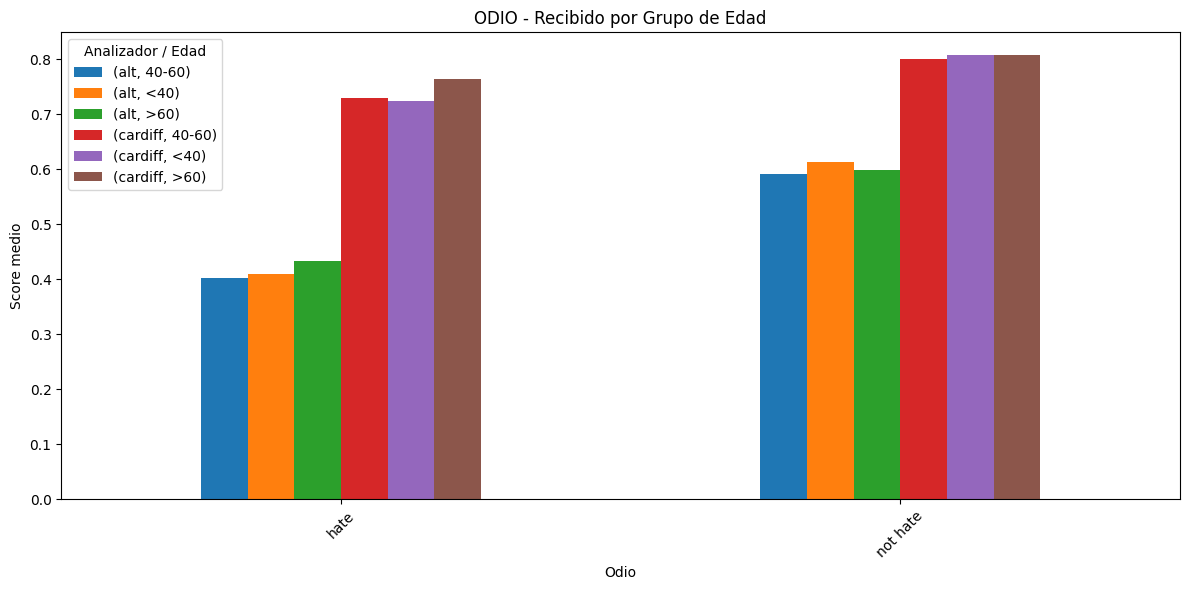

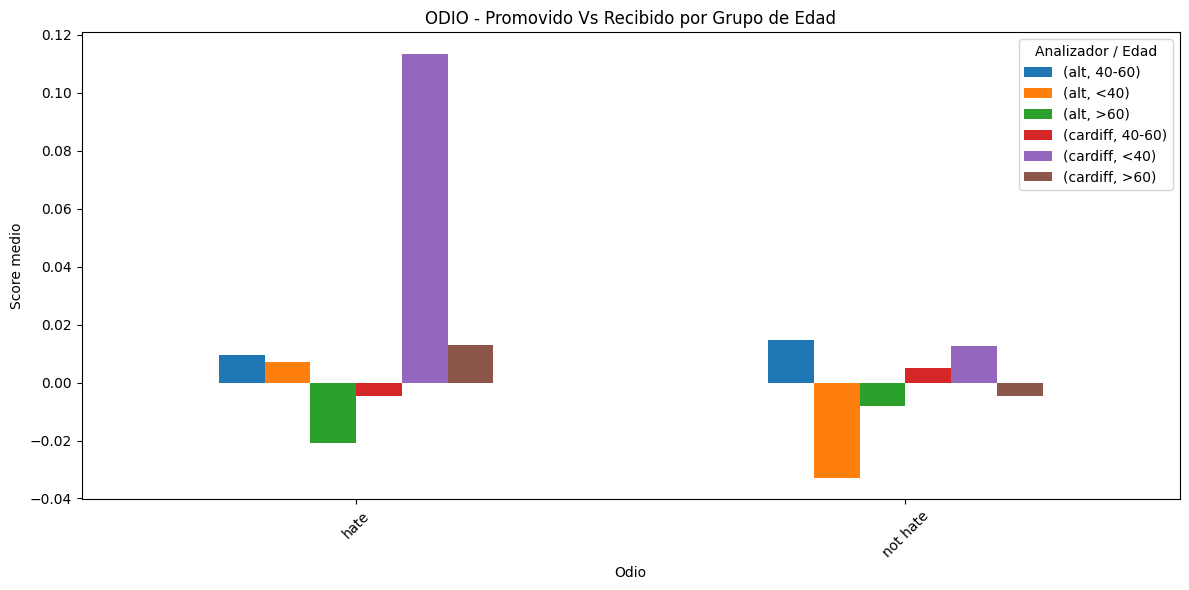

In [33]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import os

# ---------- CONFIGURACIÓN ----------
RUTA_JSON = 'Spain_Completo_analizado.json'  # <- CAMBIA AQUÍ
CSV_SALIDA = 'resultados_analisis.csv'

def clasificar_edad(age):
    try:
        age = int(age)
        if age < 40:
            return '<40'
        elif age <= 60:
            return '40-60'
        else:
            return '>60'
    except:
        return 'desconocido'

def analizar_categoria_por_edad(json_data, categoria, tipo_analisis):
    resultados = defaultdict(lambda: defaultdict(list))

    for politico in json_data:
        grupo = clasificar_edad(politico.get('age'))

        for tweet in politico.get('tweets', []):
            entradas = tweet.get('replies', []) if tipo_analisis == 'recibido' else [tweet]
            for entrada in entradas:
                if not entrada:
                    continue
                analysis = entrada.get('analysis')
                if not analysis:
                    continue

                if categoria == 'sentimiento':
                    sentiment = analysis.get('sentiment')
                    if sentiment and isinstance(sentiment, dict):
                        label = sentiment.get('label')
                        score = sentiment.get('score')
                        if label in ['positive', 'neutral', 'negative'] and score is not None:
                            resultados['cardiff'][(grupo, label)].append(score)

                    stanza = analysis.get('sentiment_stanza')
                    mapa = {0: 'negative', 1: 'neutral', 2: 'positive'}
                    if stanza in mapa:
                        resultados['stanza'][(grupo, mapa[stanza])].append(1.0)

                    label_alt = entrada.get('sentiment_alt_label')
                    score_alt = entrada.get('sentiment_alt_score')
                    if label_alt in ['positive', 'neutral', 'negative'] and score_alt is not None:
                        resultados['alt'][(grupo, label_alt)].append(score_alt)

                elif categoria == 'emocion':
                    emociones = analysis.get('emotions', [])
                    for emocion in emociones:
                        label = emocion.get('label')
                        score = emocion.get('score')
                        if label and score is not None:
                            resultados['cardiff'][(grupo, label)].append(score)

                elif categoria == 'odio':
                    odio = analysis.get('hate')
                    if odio and isinstance(odio, dict):
                        label = odio.get('label')
                        score = odio.get('score')
                        if label in ['hate', 'not hate'] and score is not None:
                            resultados['cardiff'][(grupo, label)].append(score)

                    label_alt = entrada.get('hate_alt_label')
                    score_alt = entrada.get('hate_alt_score')
                    if label_alt in ['hate', 'none']:
                        label_alt = 'not hate' if label_alt == 'none' else 'hate'
                        if score_alt is not None:
                            resultados['alt'][(grupo, label_alt)].append(score_alt)

    filas = []
    for analizador, grupos in resultados.items():
        for (grupo, clase), scores in grupos.items():
            media = sum(scores) / len(scores) if scores else 0
            filas.append({
                'analizador': analizador,
                'grupo': grupo,
                'clase': clase,
                'score_medio': media,
                'tipo_analisis': tipo_analisis,
                'categoria': categoria
            })

    return pd.DataFrame(filas)

# ---------- CARGAR JSON ----------
with open(RUTA_JSON, 'r', encoding='utf-8') as f:
    data = json.load(f)

# ---------- GENERAR TODAS LAS TABLAS ----------
dfs = []
for categoria in ['sentimiento', 'emocion', 'odio']:
    for tipo in ['promovido', 'recibido']:
        df = analizar_categoria_por_edad(data, categoria, tipo)
        dfs.append(df)

# ---------- COMPARATIVAS PROMOVIDO VS RECIBIDO ----------
comparativas = []
for categoria in ['sentimiento', 'emocion', 'odio']:
    df_p = [d for d in dfs if d['categoria'].iloc[0] == categoria and d['tipo_analisis'].iloc[0] == 'promovido'][0]
    df_r = [d for d in dfs if d['categoria'].iloc[0] == categoria and d['tipo_analisis'].iloc[0] == 'recibido'][0]
    merged = pd.merge(df_p, df_r, on=['analizador', 'grupo', 'clase'], suffixes=('_p', '_r'))
    merged['score_medio'] = merged['score_medio_p'] - merged['score_medio_r']
    merged['tipo_analisis'] = 'promovido_vs_recibido'
    merged['categoria'] = categoria
    comparativas.append(merged[['analizador', 'grupo', 'clase', 'score_medio', 'tipo_analisis', 'categoria']])

# ---------- UNIR Y GUARDAR ----------
df_total = pd.concat(dfs + comparativas, ignore_index=True)
df_total.to_csv(CSV_SALIDA, index=False)

# ---------- GRAFICAR TODO ----------
for categoria in ['sentimiento', 'emocion', 'odio']:
    for tipo in ['promovido', 'recibido', 'promovido_vs_recibido']:
        df_plot = df_total[(df_total['categoria'] == categoria) & (df_total['tipo_analisis'] == tipo)]
        if not df_plot.empty:
            pivot = df_plot.pivot_table(index='clase', columns=['analizador', 'grupo'], values='score_medio')
            pivot.plot(kind='bar', figsize=(12, 6), title=f"{categoria.upper()} - {tipo.replace('_', ' ').title()} por Grupo de Edad")
            plt.ylabel("Score medio")
            plt.xlabel(categoria.title())
            plt.xticks(rotation=45)
            plt.legend(title="Analizador / Edad")
            plt.tight_layout()
            plt.show()


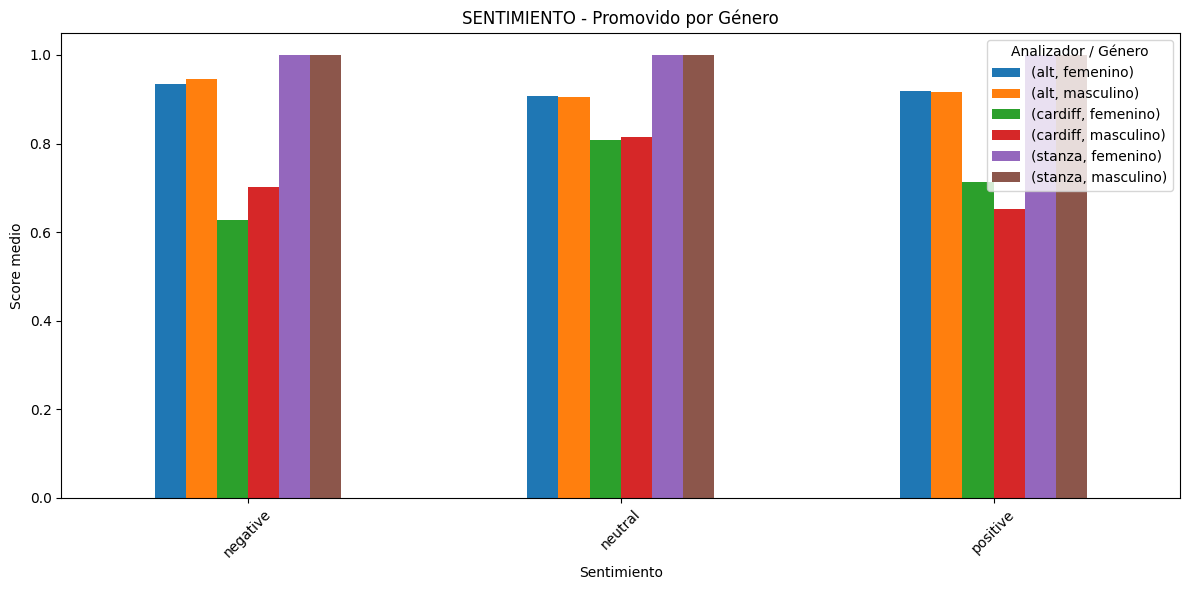

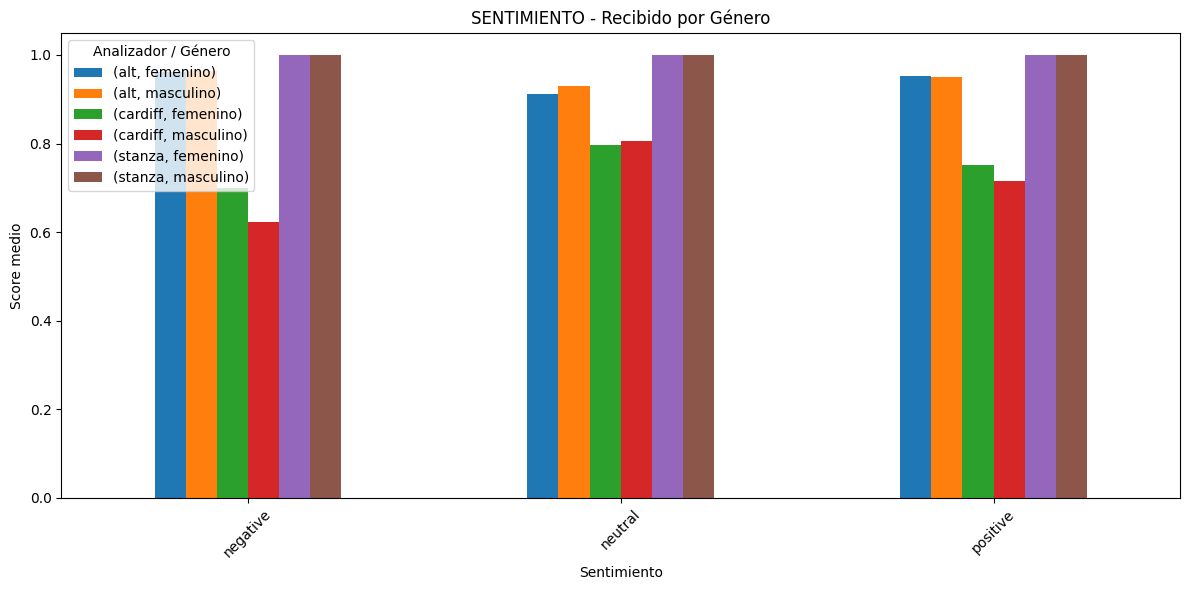

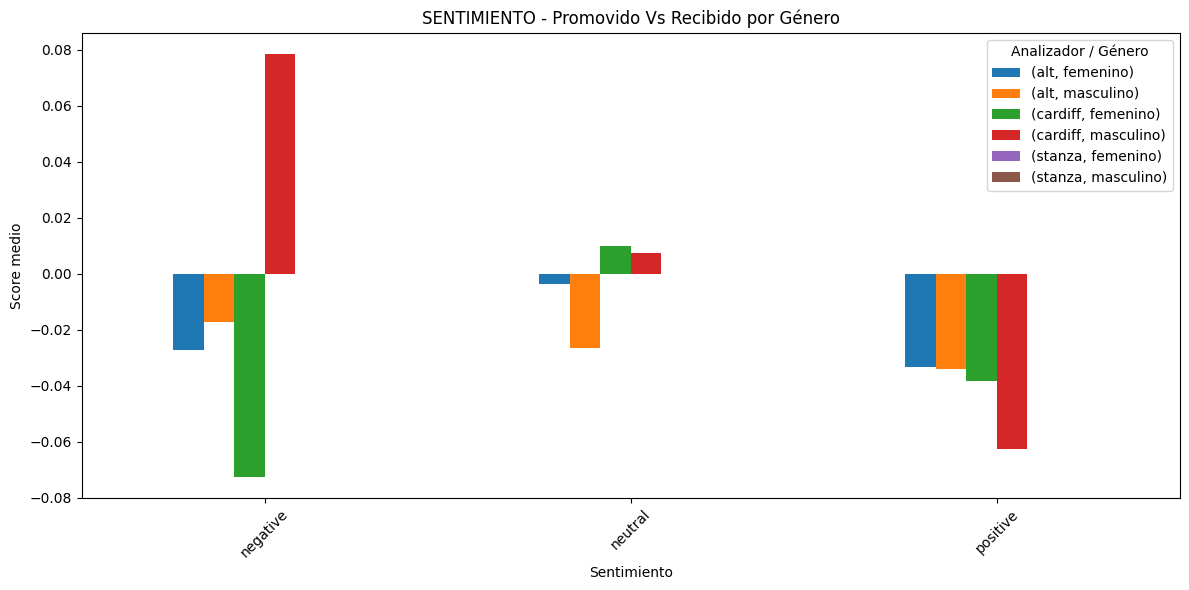

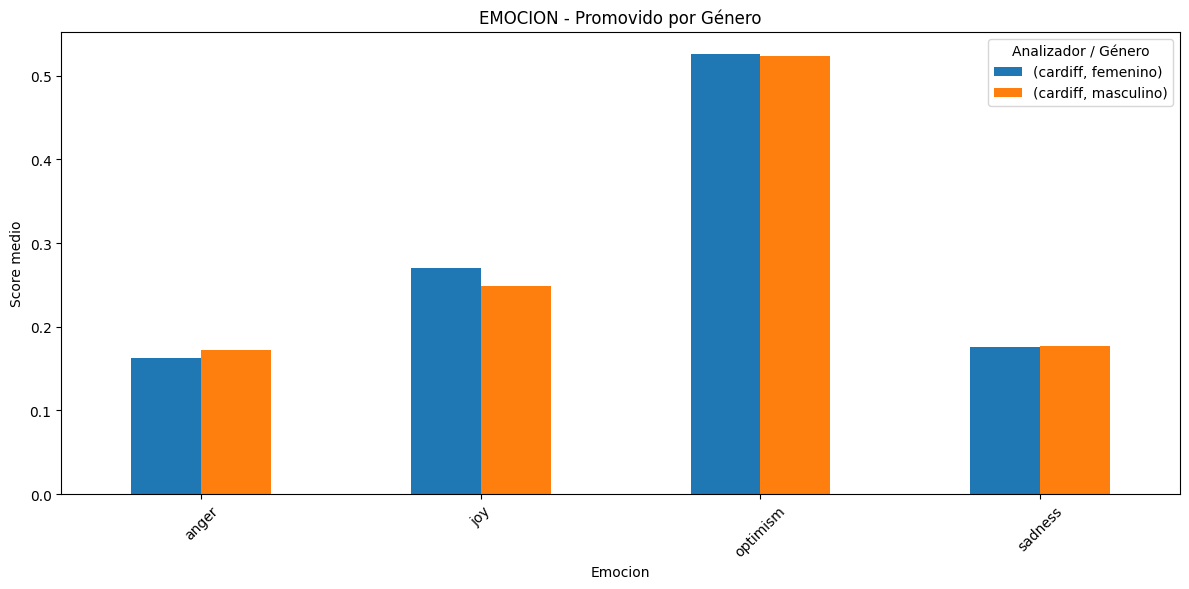

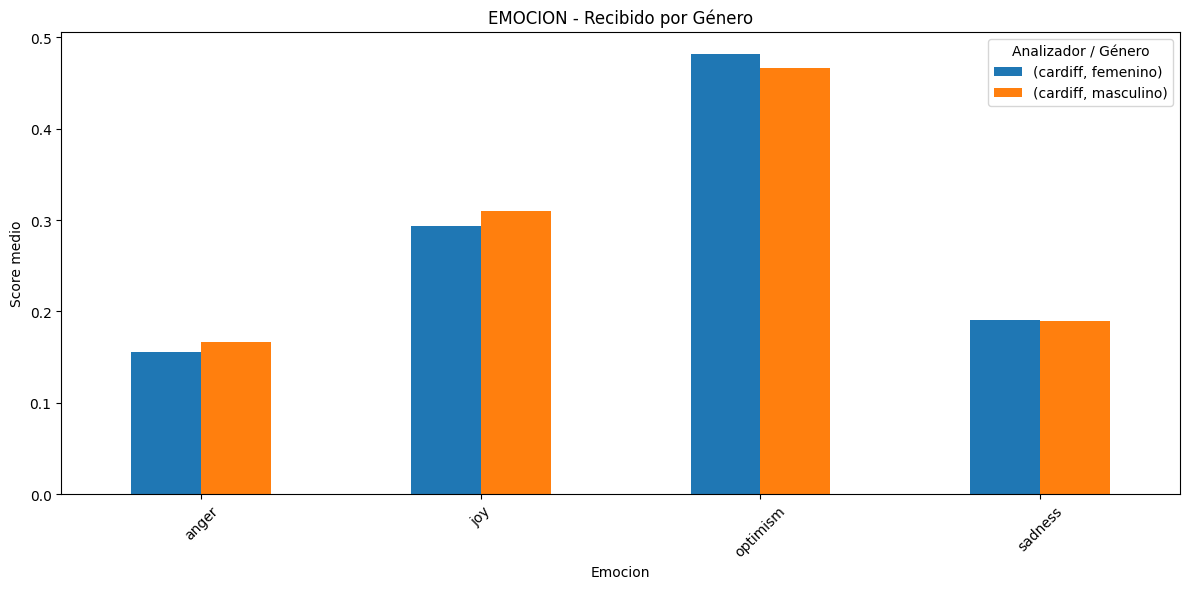

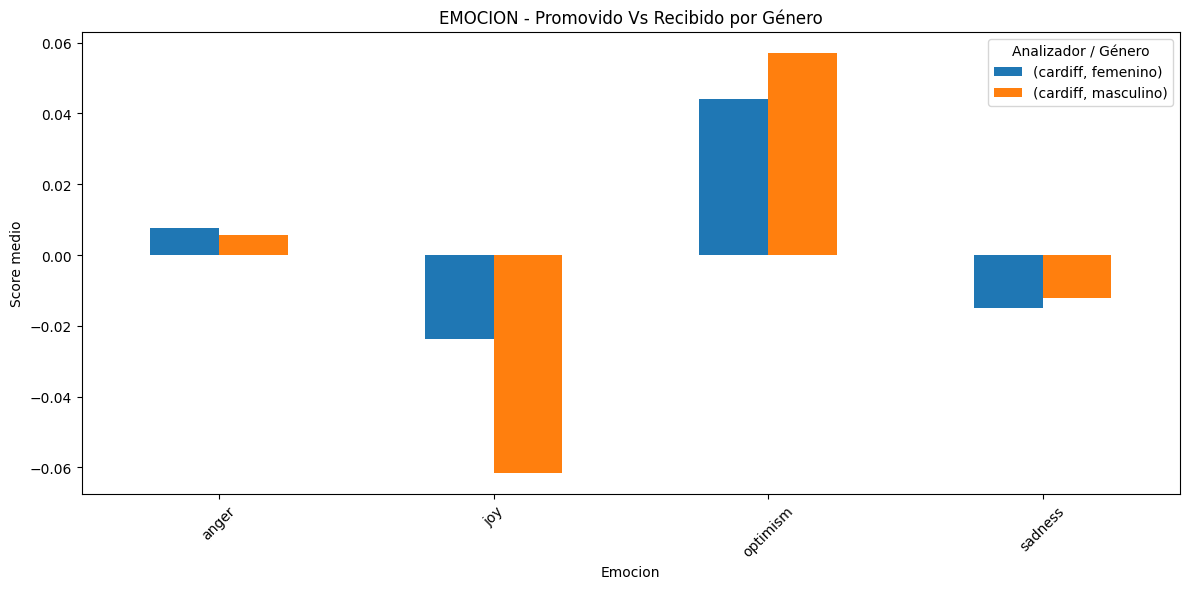

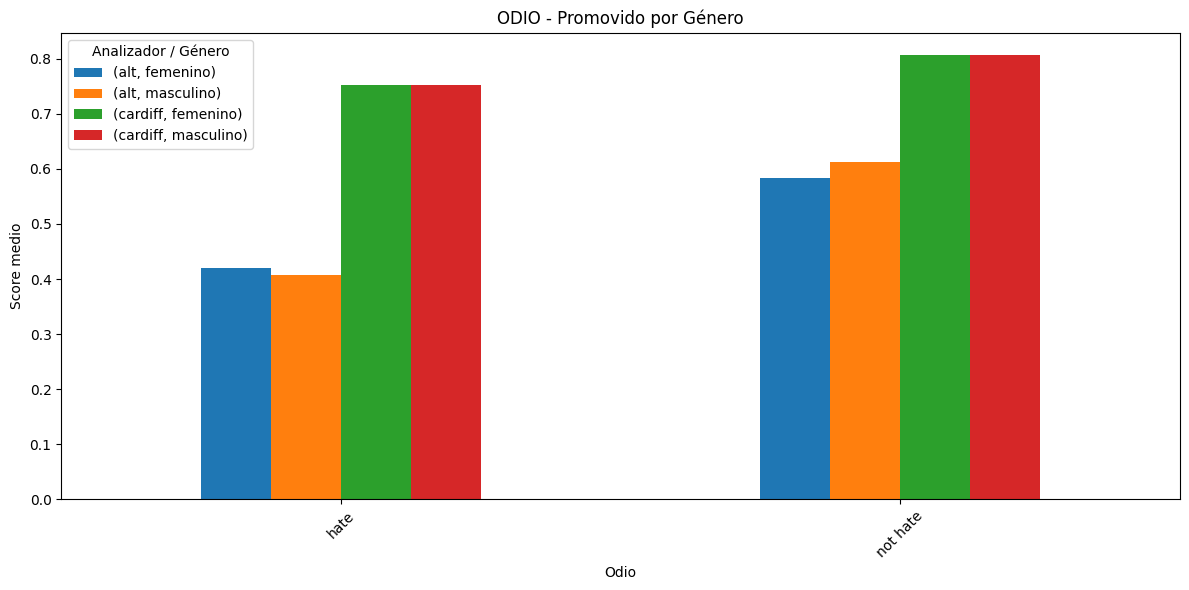

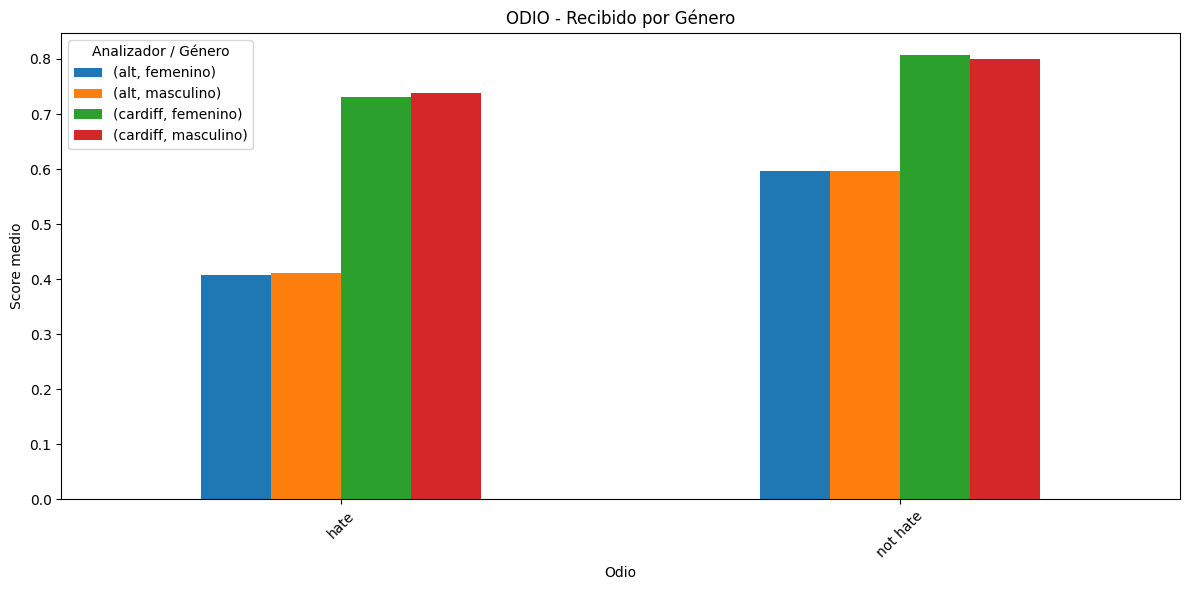

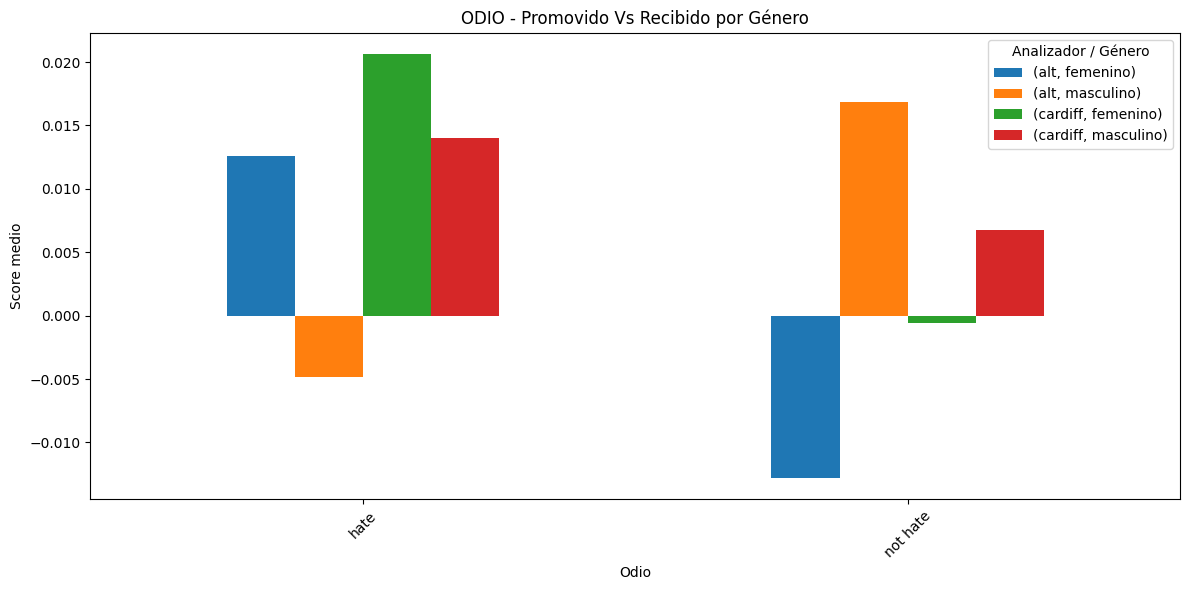

In [34]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import os

# ---------- CONFIGURACIÓN ----------
RUTA_JSON = 'Spain_Completo_analizado.json'  # ← CAMBIA AQUÍ SI NECESITAS
CSV_SALIDA = 'resultados_analisis.csv'

def analizar_categoria_por_genero(json_data, categoria, tipo_analisis):
    resultados = defaultdict(lambda: defaultdict(list))

    for politico in json_data:
        grupo = politico.get('gender', 'desconocido')

        for tweet in politico.get('tweets', []):
            entradas = tweet.get('replies', []) if tipo_analisis == 'recibido' else [tweet]
            for entrada in entradas:
                if not entrada:
                    continue
                analysis = entrada.get('analysis')
                if not analysis:
                    continue

                if categoria == 'sentimiento':
                    sentiment = analysis.get('sentiment')
                    if sentiment and isinstance(sentiment, dict):
                        label = sentiment.get('label')
                        score = sentiment.get('score')
                        if label in ['positive', 'neutral', 'negative'] and score is not None:
                            resultados['cardiff'][(grupo, label)].append(score)

                    stanza = analysis.get('sentiment_stanza')
                    mapa = {0: 'negative', 1: 'neutral', 2: 'positive'}
                    if stanza in mapa:
                        resultados['stanza'][(grupo, mapa[stanza])].append(1.0)

                    label_alt = entrada.get('sentiment_alt_label')
                    score_alt = entrada.get('sentiment_alt_score')
                    if label_alt in ['positive', 'neutral', 'negative'] and score_alt is not None:
                        resultados['alt'][(grupo, label_alt)].append(score_alt)

                elif categoria == 'emocion':
                    emociones = analysis.get('emotions', [])
                    for emocion in emociones:
                        label = emocion.get('label')
                        score = emocion.get('score')
                        if label and score is not None:
                            resultados['cardiff'][(grupo, label)].append(score)

                elif categoria == 'odio':
                    odio = analysis.get('hate')
                    if odio and isinstance(odio, dict):
                        label = odio.get('label')
                        score = odio.get('score')
                        if label in ['hate', 'not hate'] and score is not None:
                            resultados['cardiff'][(grupo, label)].append(score)

                    label_alt = entrada.get('hate_alt_label')
                    score_alt = entrada.get('hate_alt_score')
                    if label_alt in ['hate', 'none']:
                        label_alt = 'not hate' if label_alt == 'none' else 'hate'
                        if score_alt is not None:
                            resultados['alt'][(grupo, label_alt)].append(score_alt)

    filas = []
    for analizador, grupos in resultados.items():
        for (grupo, clase), scores in grupos.items():
            media = sum(scores) / len(scores) if scores else 0
            filas.append({
                'analizador': analizador,
                'grupo': grupo,
                'clase': clase,
                'score_medio': media,
                'tipo_analisis': tipo_analisis,
                'categoria': categoria
            })

    return pd.DataFrame(filas)

# ---------- CARGAR JSON ----------
with open(RUTA_JSON, 'r', encoding='utf-8') as f:
    data = json.load(f)

# ---------- GENERAR TODAS LAS TABLAS ----------
dfs = []
for categoria in ['sentimiento', 'emocion', 'odio']:
    for tipo in ['promovido', 'recibido']:
        df = analizar_categoria_por_genero(data, categoria, tipo)
        dfs.append(df)

# ---------- COMPARATIVAS PROMOVIDO VS RECIBIDO ----------
comparativas = []
for categoria in ['sentimiento', 'emocion', 'odio']:
    df_p = [d for d in dfs if d['categoria'].iloc[0] == categoria and d['tipo_analisis'].iloc[0] == 'promovido'][0]
    df_r = [d for d in dfs if d['categoria'].iloc[0] == categoria and d['tipo_analisis'].iloc[0] == 'recibido'][0]
    merged = pd.merge(df_p, df_r, on=['analizador', 'grupo', 'clase'], suffixes=('_p', '_r'))
    merged['score_medio'] = merged['score_medio_p'] - merged['score_medio_r']
    merged['tipo_analisis'] = 'promovido_vs_recibido'
    merged['categoria'] = categoria
    comparativas.append(merged[['analizador', 'grupo', 'clase', 'score_medio', 'tipo_analisis', 'categoria']])

# ---------- UNIR Y GUARDAR ----------
df_total = pd.concat(dfs + comparativas, ignore_index=True)
df_total.to_csv(CSV_SALIDA, mode='a', index=False, header=not os.path.exists(CSV_SALIDA))

# ---------- GRAFICAR TODO ----------
for categoria in ['sentimiento', 'emocion', 'odio']:
    for tipo in ['promovido', 'recibido', 'promovido_vs_recibido']:
        df_plot = df_total[(df_total['categoria'] == categoria) & (df_total['tipo_analisis'] == tipo)]
        if not df_plot.empty:
            pivot = df_plot.pivot_table(index='clase', columns=['analizador', 'grupo'], values='score_medio')
            pivot.plot(kind='bar', figsize=(12, 6), title=f"{categoria.upper()} - {tipo.replace('_', ' ').title()} por Género")
            plt.ylabel("Score medio")
            plt.xlabel(categoria.title())
            plt.xticks(rotation=45)
            plt.legend(title="Analizador / Género")
            plt.tight_layout()
            plt.show()


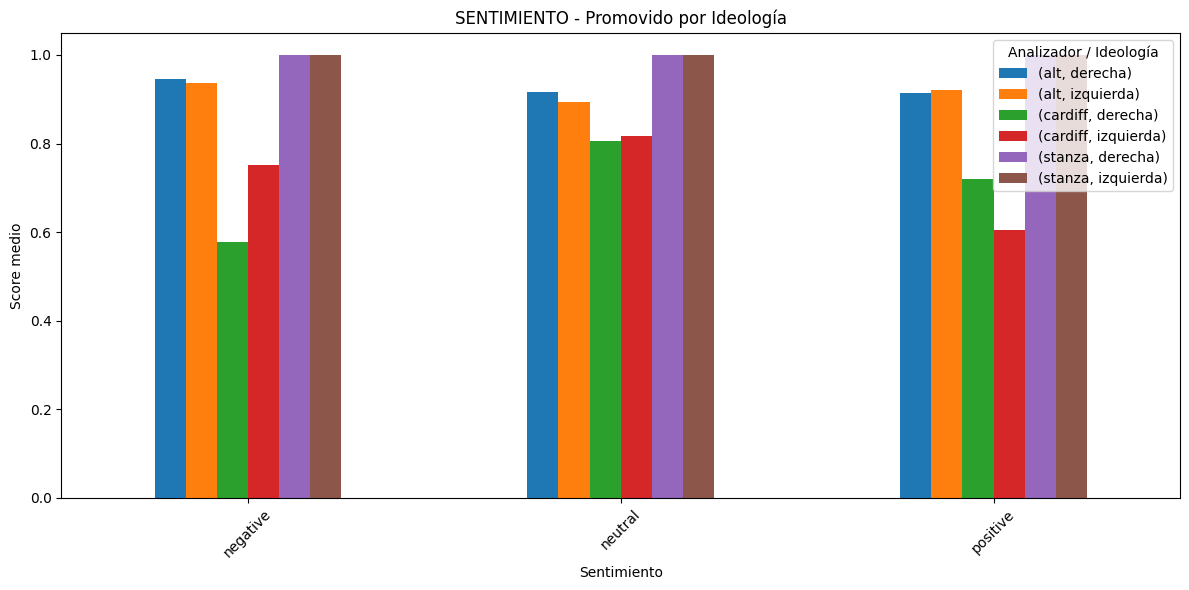

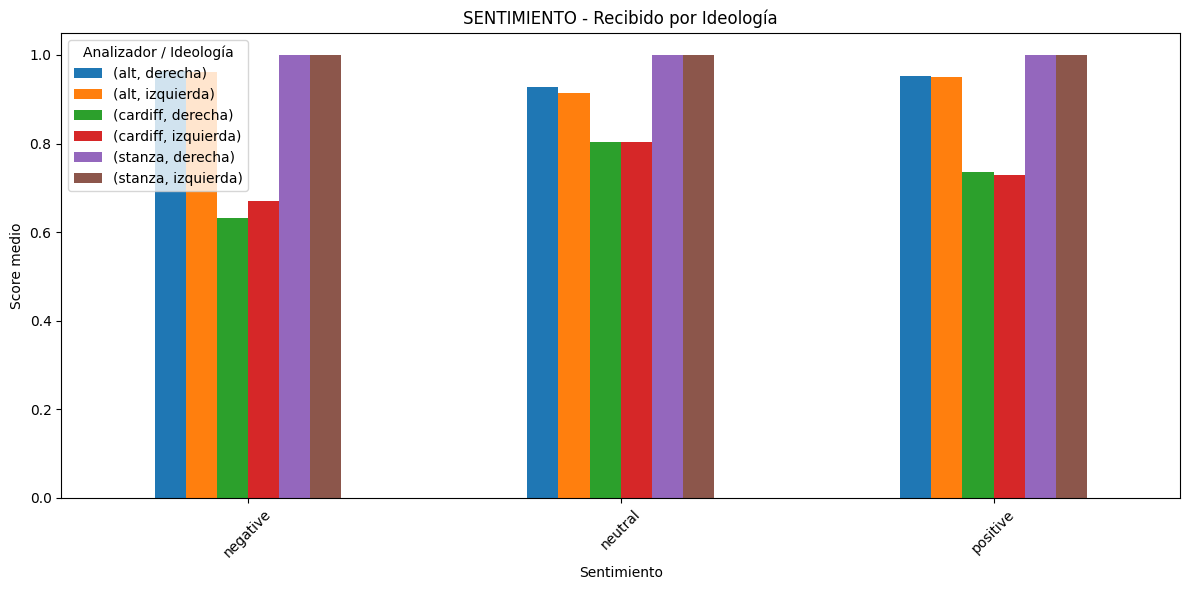

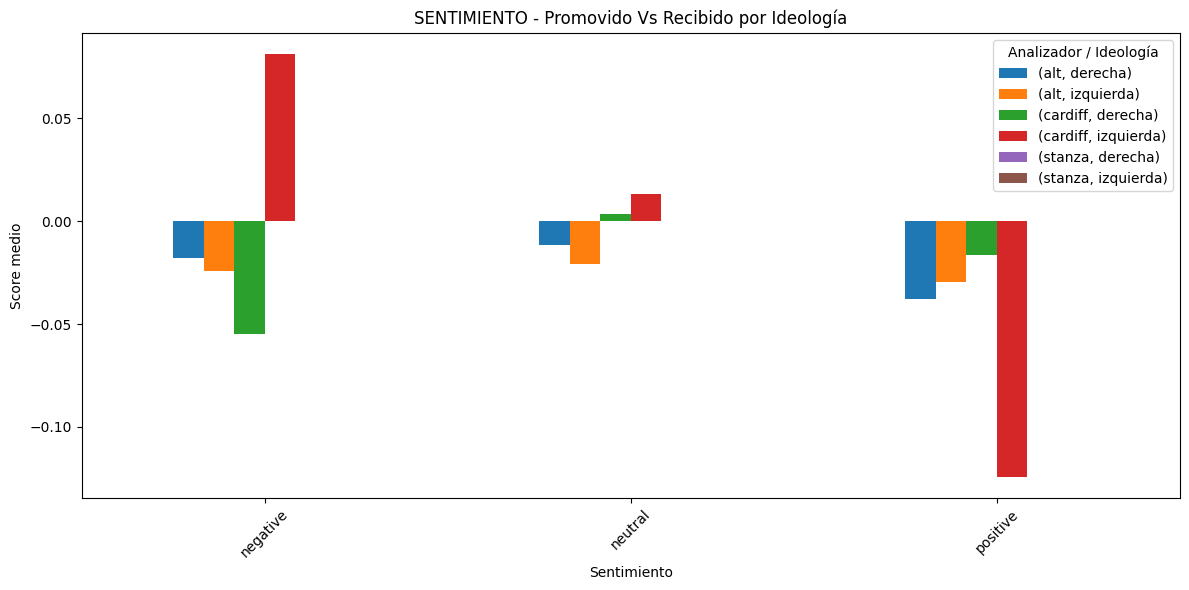

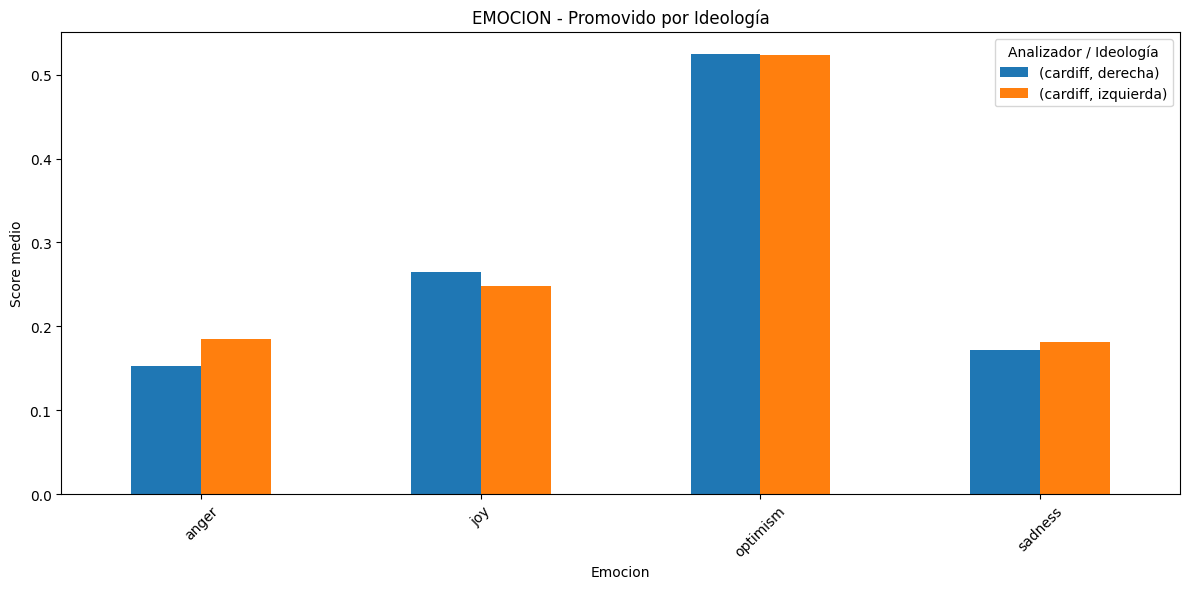

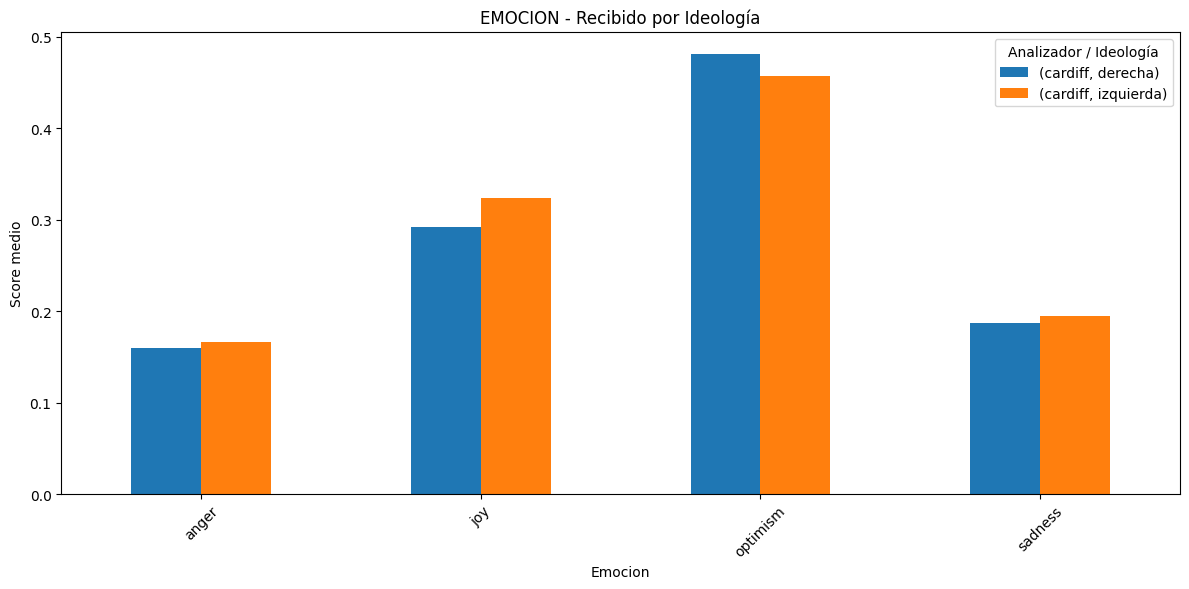

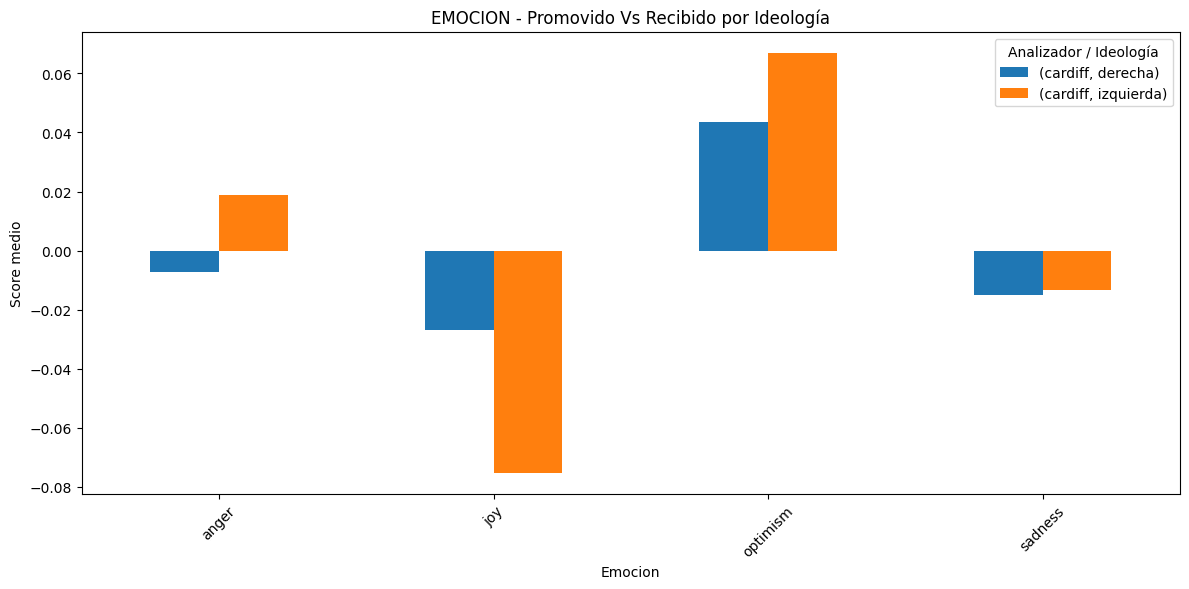

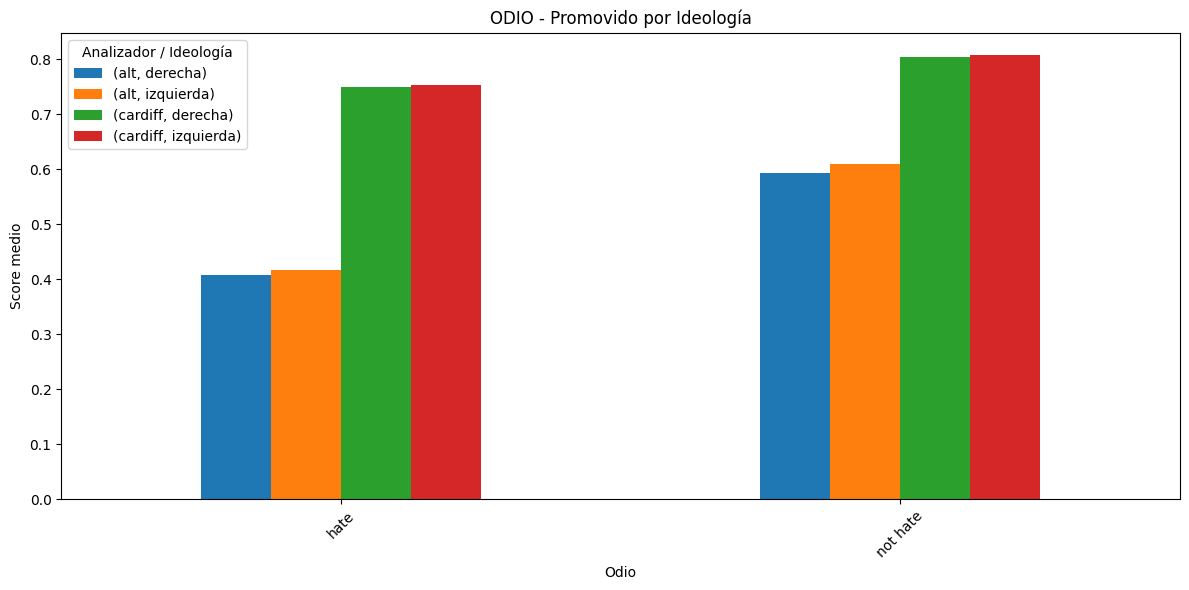

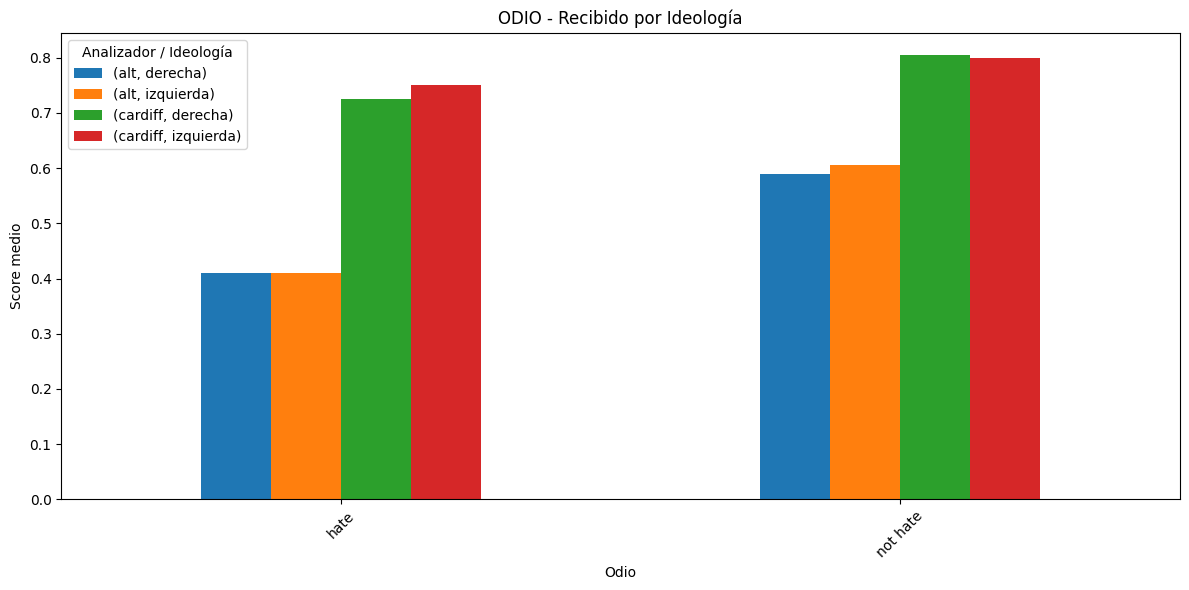

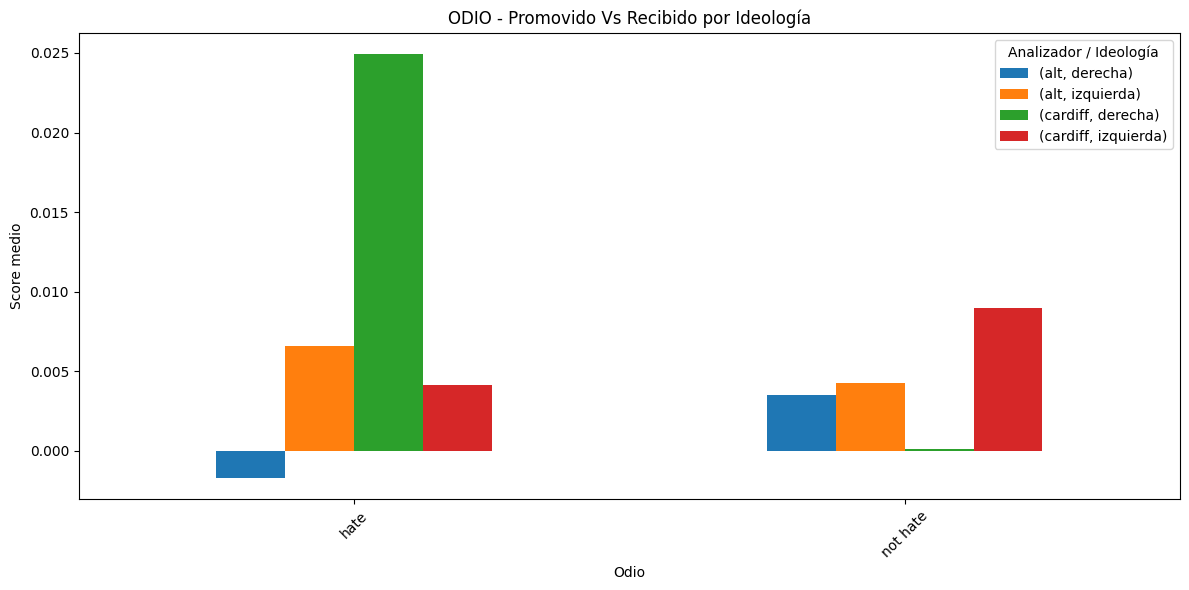

In [35]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import os

# ---------- CONFIGURACIÓN ----------
RUTA_JSON = 'Spain_Completo_analizado.json'  # ← CAMBIA AQUÍ SI NECESITAS
CSV_SALIDA = 'resultados_analisis.csv'

def analizar_categoria_por_ideologia(json_data, categoria, tipo_analisis):
    resultados = defaultdict(lambda: defaultdict(list))

    for politico in json_data:
        grupo = politico.get('ideologia', 'desconocido')  # Usa directamente el campo del JSON

        for tweet in politico.get('tweets', []):
            entradas = tweet.get('replies', []) if tipo_analisis == 'recibido' else [tweet]
            for entrada in entradas:
                if not entrada:
                    continue
                analysis = entrada.get('analysis')
                if not analysis:
                    continue

                if categoria == 'sentimiento':
                    sentiment = analysis.get('sentiment')
                    if sentiment and isinstance(sentiment, dict):
                        label = sentiment.get('label')
                        score = sentiment.get('score')
                        if label in ['positive', 'neutral', 'negative'] and score is not None:
                            resultados['cardiff'][(grupo, label)].append(score)

                    stanza = analysis.get('sentiment_stanza')
                    mapa = {0: 'negative', 1: 'neutral', 2: 'positive'}
                    if stanza in mapa:
                        resultados['stanza'][(grupo, mapa[stanza])].append(1.0)

                    label_alt = entrada.get('sentiment_alt_label')
                    score_alt = entrada.get('sentiment_alt_score')
                    if label_alt in ['positive', 'neutral', 'negative'] and score_alt is not None:
                        resultados['alt'][(grupo, label_alt)].append(score_alt)

                elif categoria == 'emocion':
                    emociones = analysis.get('emotions', [])
                    for emocion in emociones:
                        label = emocion.get('label')
                        score = emocion.get('score')
                        if label and score is not None:
                            resultados['cardiff'][(grupo, label)].append(score)

                elif categoria == 'odio':
                    odio = analysis.get('hate')
                    if odio and isinstance(odio, dict):
                        label = odio.get('label')
                        score = odio.get('score')
                        if label in ['hate', 'not hate'] and score is not None:
                            resultados['cardiff'][(grupo, label)].append(score)

                    label_alt = entrada.get('hate_alt_label')
                    score_alt = entrada.get('hate_alt_score')
                    if label_alt in ['hate', 'none']:
                        label_alt = 'not hate' if label_alt == 'none' else 'hate'
                        if score_alt is not None:
                            resultados['alt'][(grupo, label_alt)].append(score_alt)

    filas = []
    for analizador, grupos in resultados.items():
        for (grupo, clase), scores in grupos.items():
            media = sum(scores) / len(scores) if scores else 0
            filas.append({
                'analizador': analizador,
                'grupo': grupo,
                'clase': clase,
                'score_medio': media,
                'tipo_analisis': tipo_analisis,
                'categoria': categoria
            })

    return pd.DataFrame(filas)

# ---------- CARGAR JSON ----------
with open(RUTA_JSON, 'r', encoding='utf-8') as f:
    data = json.load(f)

# ---------- GENERAR TODAS LAS TABLAS ----------
dfs = []
for categoria in ['sentimiento', 'emocion', 'odio']:
    for tipo in ['promovido', 'recibido']:
        df = analizar_categoria_por_ideologia(data, categoria, tipo)
        dfs.append(df)

# ---------- COMPARATIVAS PROMOVIDO VS RECIBIDO ----------
comparativas = []
for categoria in ['sentimiento', 'emocion', 'odio']:
    df_p = [d for d in dfs if d['categoria'].iloc[0] == categoria and d['tipo_analisis'].iloc[0] == 'promovido'][0]
    df_r = [d for d in dfs if d['categoria'].iloc[0] == categoria and d['tipo_analisis'].iloc[0] == 'recibido'][0]
    merged = pd.merge(df_p, df_r, on=['analizador', 'grupo', 'clase'], suffixes=('_p', '_r'))
    merged['score_medio'] = merged['score_medio_p'] - merged['score_medio_r']
    merged['tipo_analisis'] = 'promovido_vs_recibido'
    merged['categoria'] = categoria
    comparativas.append(merged[['analizador', 'grupo', 'clase', 'score_medio', 'tipo_analisis', 'categoria']])

# ---------- UNIR Y GUARDAR ----------
df_total = pd.concat(dfs + comparativas, ignore_index=True)
df_total.to_csv(CSV_SALIDA, mode='a', index=False, header=not os.path.exists(CSV_SALIDA))

# ---------- GRAFICAR TODO ----------
for categoria in ['sentimiento', 'emocion', 'odio']:
    for tipo in ['promovido', 'recibido', 'promovido_vs_recibido']:
        df_plot = df_total[(df_total['categoria'] == categoria) & (df_total['tipo_analisis'] == tipo)]
        if not df_plot.empty:
            pivot = df_plot.pivot_table(index='clase', columns=['analizador', 'grupo'], values='score_medio')
            pivot.plot(kind='bar', figsize=(12, 6), title=f"{categoria.upper()} - {tipo.replace('_', ' ').title()} por Ideología")
            plt.ylabel("Score medio")
            plt.xlabel(categoria.title())
            plt.xticks(rotation=45)
            plt.legend(title="Analizador / Ideología")
            plt.tight_layout()
            plt.show()


,atributo,grupo,analizador,accuracy,n
0,gender,femenino,cardiff,0.637405,262
1,gender,masculino,cardiff,0.632353,408
2,gender,femenino,stanza,0.484733,262
3,gender,masculino,stanza,0.414216,408
4,gender,femenino,alt,0.515267,262
5,gender,masculino,alt,0.473039,408
6,age,40-60,cardiff,0.638254,481
7,age,<40,cardiff,0.722222,54
8,age,>60,cardiff,0.585185,135
9,age,40-60,stanza,0.440748,481


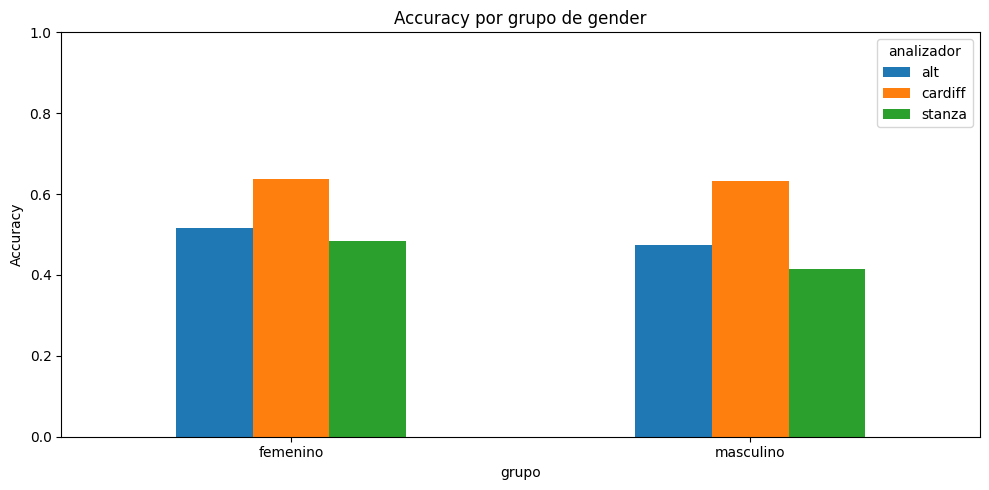

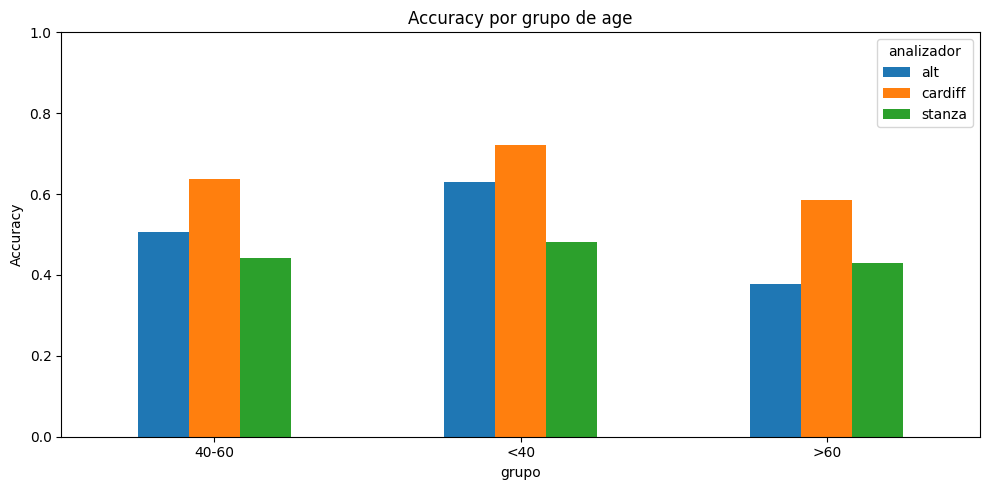

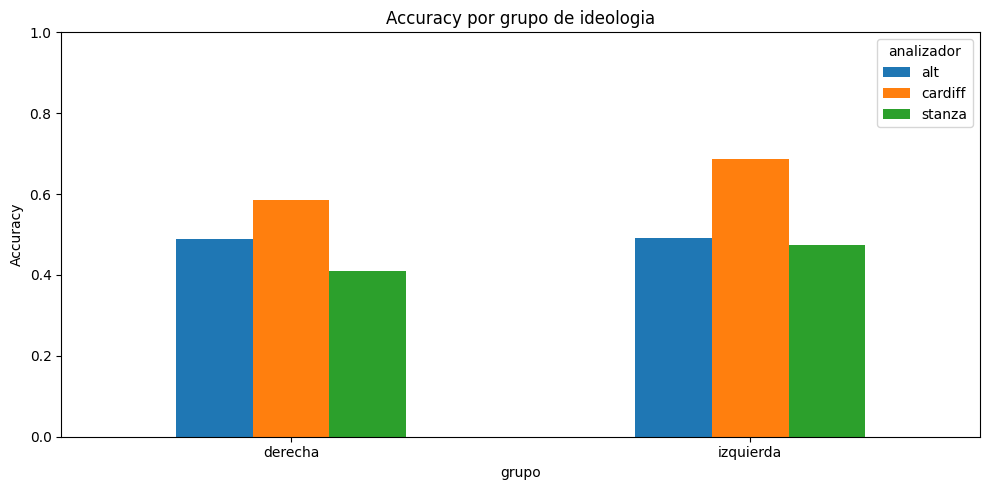

In [38]:
import json
import pandas as pd
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# ---------- CONFIGURACIÓN ----------
RUTA_JSON = 'Spain_Completo_analizado.json'  # ← CAMBIA AQUÍ

# ---------- UTILIDADES ----------
def clasificar_edad(age):
    try:
        age = int(age)
        if age < 40:
            return '<40'
        elif age <= 60:
            return '40-60'
        else:
            return '>60'
    except:
        return 'desconocido'

def evaluar_analizador_por_grupo(json_data, atributo):
    mapa_total = {-1: 'negative', 0: 'neutral', 1: 'positive'}
    analizadores = ['cardiff', 'stanza', 'alt']
    resultados = []

    for politico in json_data:
        if atributo == 'age':
            grupo = clasificar_edad(politico.get('age'))
        else:
            grupo = politico.get(atributo, 'desconocido')

        for tweet in politico.get('tweets', []):
            total = tweet.get('annotations', {}).get('Total')
            if total not in mapa_total:
                continue
            gold = mapa_total[total]

            analysis = tweet.get('analysis', {})
            pred_cardiff = analysis.get('sentiment', {}).get('label')
            pred_stanza = {0: 'negative', 1: 'neutral', 2: 'positive'}.get(analysis.get('sentiment_stanza'))
            pred_alt = tweet.get('sentiment_alt_label')

            resultados.append({
                'grupo': grupo,
                'gold': gold,
                'cardiff': pred_cardiff,
                'stanza': pred_stanza,
                'alt': pred_alt
            })

    df = pd.DataFrame(resultados)

    # Calcular accuracy por grupo y analizador
    metricas = []
    for analizador in analizadores:
        for grupo, df_grupo in df.groupby('grupo'):
            validos = df_grupo.dropna(subset=[analizador])
            if validos.empty:
                continue
            acc = accuracy_score(validos['gold'], validos[analizador])
            metricas.append({
                'atributo': atributo,
                'grupo': grupo,
                'analizador': analizador,
                'accuracy': acc,
                'n': len(validos)
            })

    return pd.DataFrame(metricas)

# ---------- CARGA DEL JSON ----------
with open(RUTA_JSON, 'r', encoding='utf-8') as f:
    data = json.load(f)

# ---------- EVALUACIONES ----------
df_genero = evaluar_analizador_por_grupo(data, 'gender')
df_edad = evaluar_analizador_por_grupo(data, 'age')
df_ideologia = evaluar_analizador_por_grupo(data, 'ideologia')

df_total = pd.concat([df_genero, df_edad, df_ideologia], ignore_index=True)

# ---------- MOSTRAR RESULTADOS ----------
display(df_total)

# ---------- GRAFICAR ----------
for atributo in df_total['atributo'].unique():
    df_attr = df_total[df_total['atributo'] == atributo]
    pivot = df_attr.pivot(index='grupo', columns='analizador', values='accuracy')
    pivot.plot(kind='bar', figsize=(10, 5), title=f"Accuracy por grupo de {atributo}")
    plt.ylabel("Accuracy")
    plt.ylim(0, 1)
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()


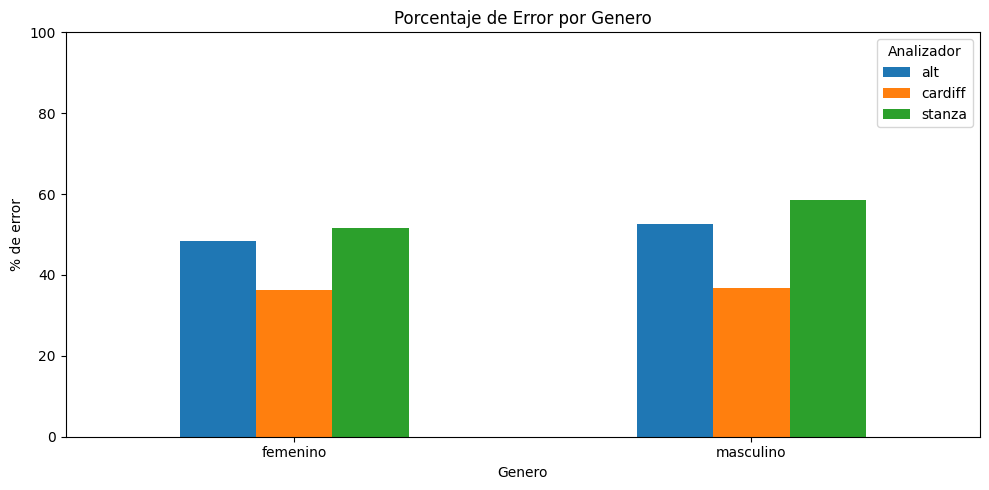

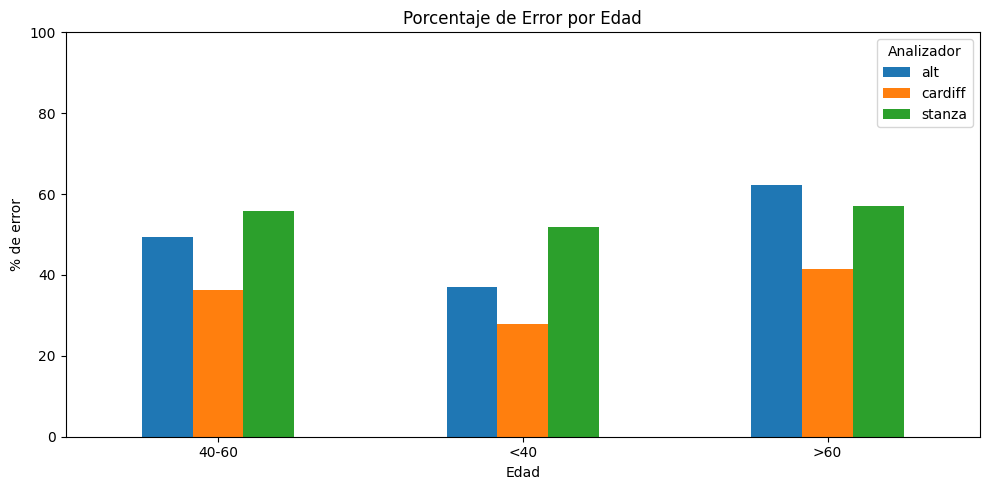

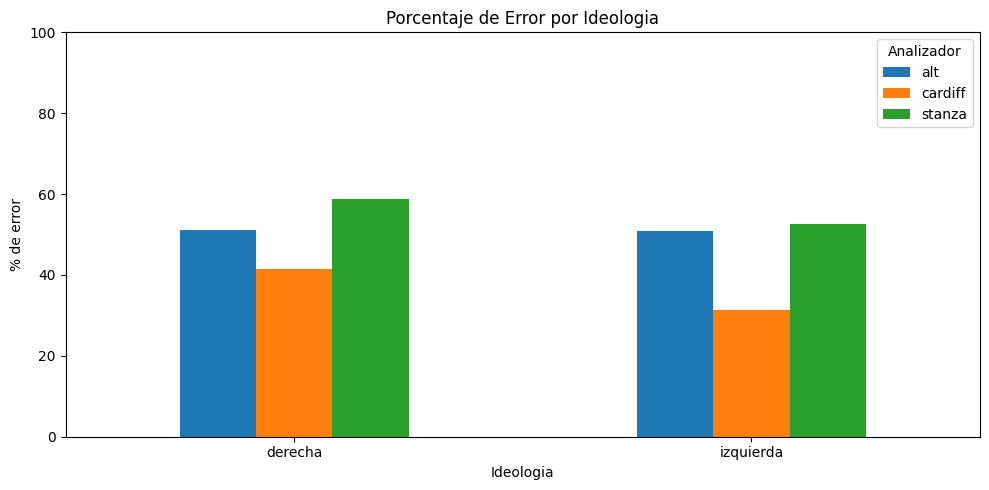

In [40]:
import json
import pandas as pd
import matplotlib.pyplot as plt

# ---------- CONFIGURACIÓN ----------
RUTA_JSON = 'Spain_Completo_analizado.json'  # ← CAMBIA AQUÍ

def clasificar_edad(age):
    try:
        age = int(age)
        if age < 40:
            return '<40'
        elif age <= 60:
            return '40-60'
        else:
            return '>60'
    except:
        return 'desconocido'

# ---------- CARGAR JSON ----------
with open(RUTA_JSON, 'r', encoding='utf-8') as f:
    data = json.load(f)

mapa_total = {-1: 'negative', 0: 'neutral', 1: 'positive'}

# ---------- CONTAR ERRORES Y TOTALES ----------
errores = []
totales = []

for politico in data:
    genero = politico.get('gender', 'desconocido')
    edad = clasificar_edad(politico.get('age'))
    ideologia = politico.get('ideologia', 'desconocido')

    for tweet in politico.get('tweets', []):
        gold_raw = tweet.get('annotations', {}).get('Total')
        if gold_raw not in mapa_total:
            continue
        gold = mapa_total[gold_raw]

        analysis = tweet.get('analysis', {})
        pred_cardiff = analysis.get('sentiment', {}).get('label')
        pred_stanza = {0: 'negative', 1: 'neutral', 2: 'positive'}.get(analysis.get('sentiment_stanza'))
        pred_alt = tweet.get('sentiment_alt_label')

        for analizador, pred in [('cardiff', pred_cardiff), ('stanza', pred_stanza), ('alt', pred_alt)]:
            totales.append({'analizador': analizador, 'genero': genero, 'edad': edad, 'ideologia': ideologia})
            if pred and pred != gold:
                errores.append({'analizador': analizador, 'genero': genero, 'edad': edad, 'ideologia': ideologia})

df_errores = pd.DataFrame(errores)
df_totales = pd.DataFrame(totales)

# ---------- CALCULAR PORCENTAJES ----------
def calcular_porcentajes(df_errores, df_totales, atributo):
    errores_group = df_errores.groupby(['analizador', atributo]).size()
    totales_group = df_totales.groupby(['analizador', atributo]).size()
    porcentaje = (errores_group / totales_group).unstack().fillna(0) * 100
    return porcentaje.T  # Transponemos para que los grupos estén en X

# ---------- GRAFICAR PORCENTAJES ----------
for atributo in ['genero', 'edad', 'ideologia']:
    porcentaje_df = calcular_porcentajes(df_errores, df_totales, atributo)
    porcentaje_df.plot(kind='bar', figsize=(10, 5), title=f"Porcentaje de Error por {atributo.capitalize()}")
    plt.ylabel("% de error")
    plt.xlabel(atributo.capitalize())
    plt.xticks(rotation=0)
    plt.ylim(0, 100)
    plt.legend(title="Analizador")
    plt.tight_layout()
    plt.show()


**INTENTO 2**


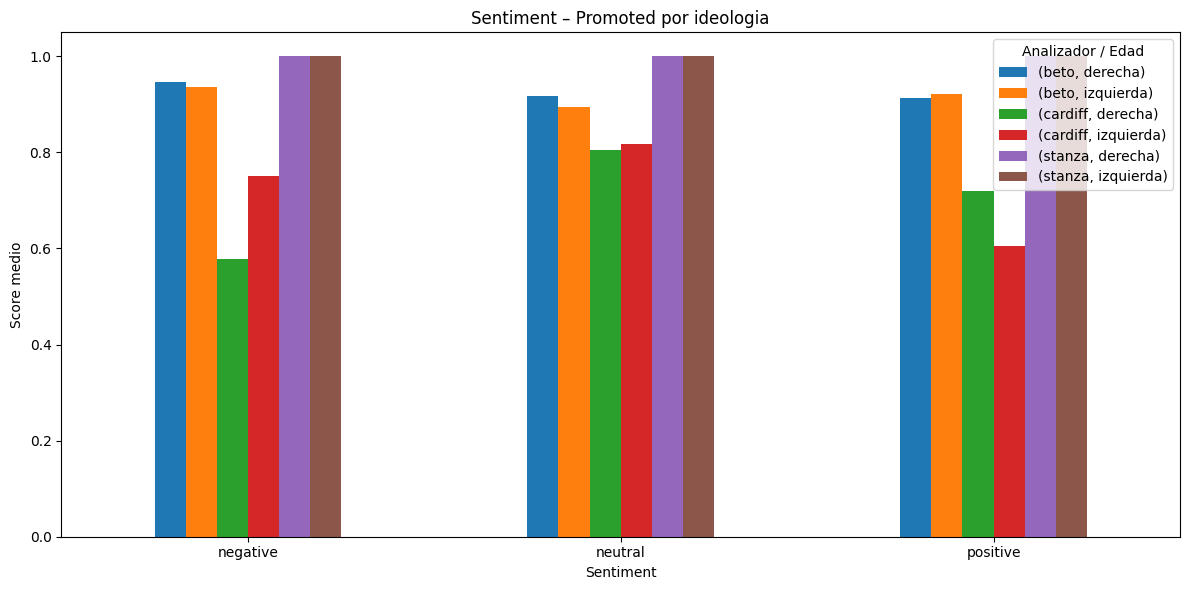

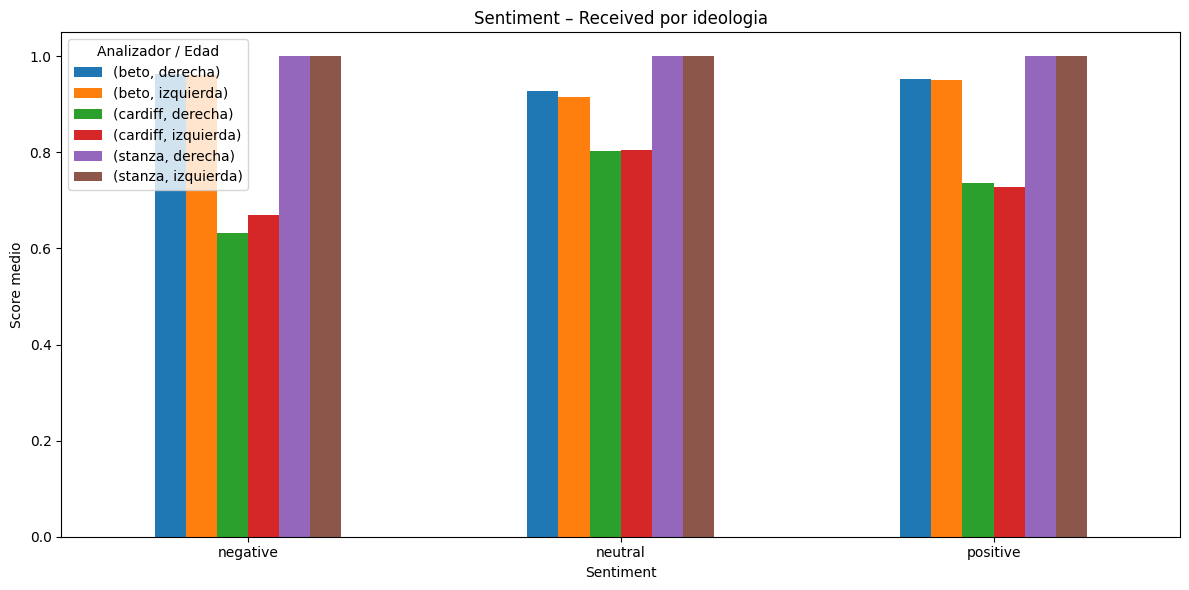

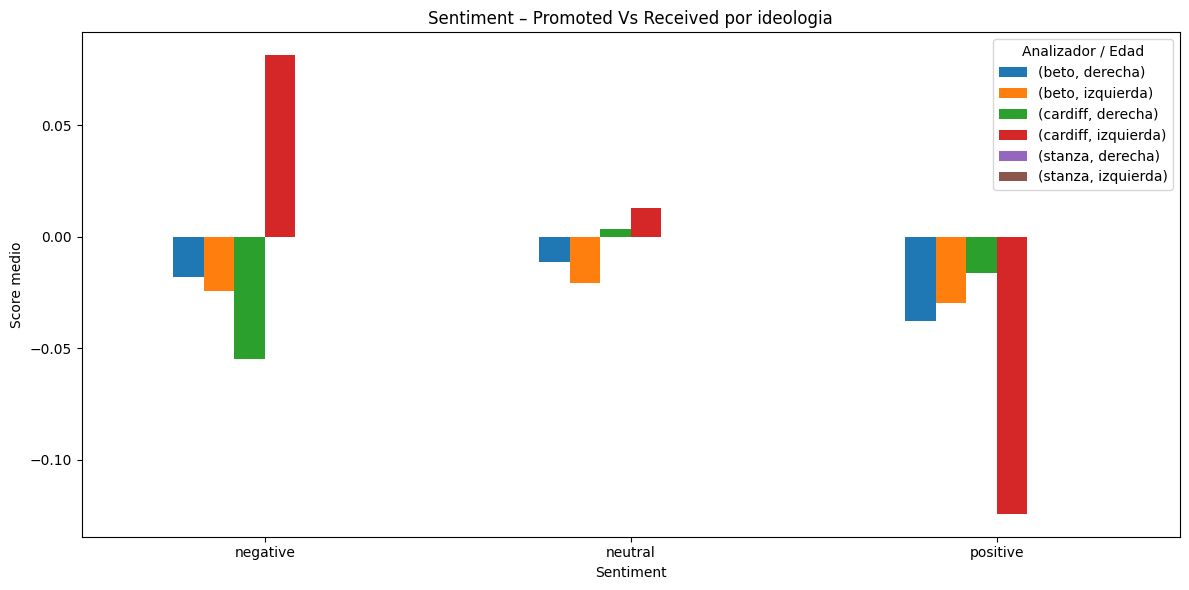

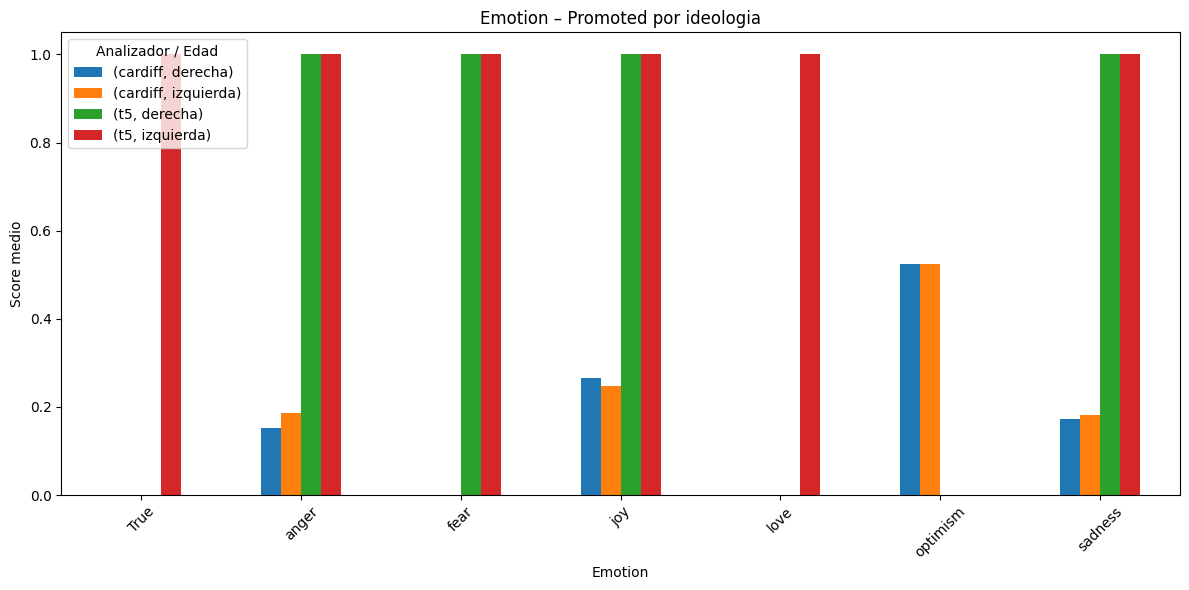

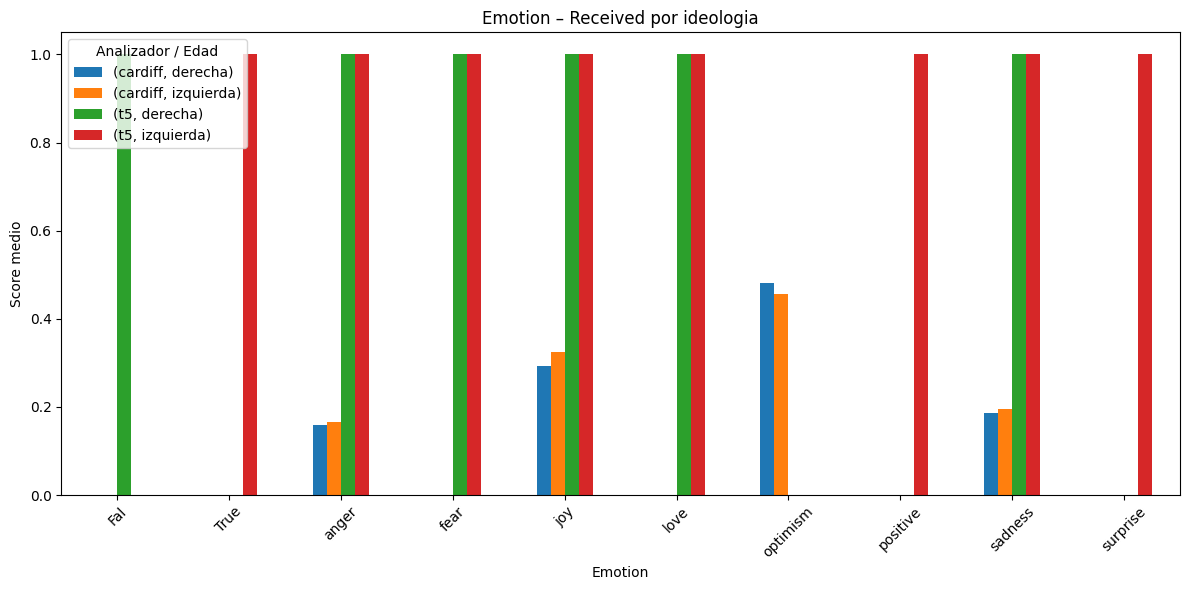

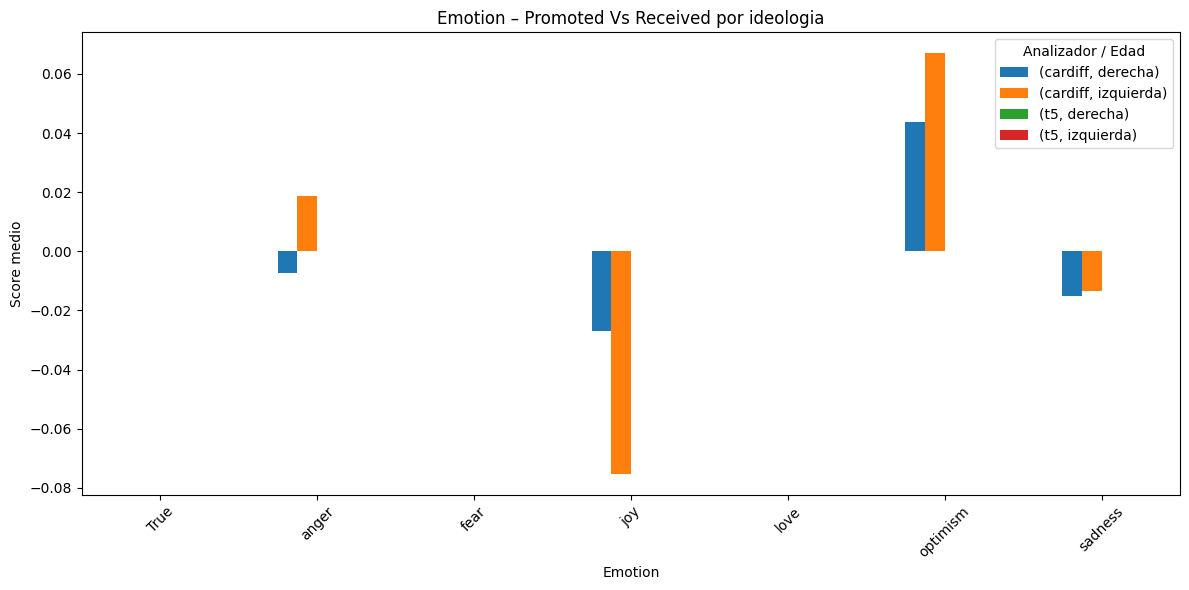

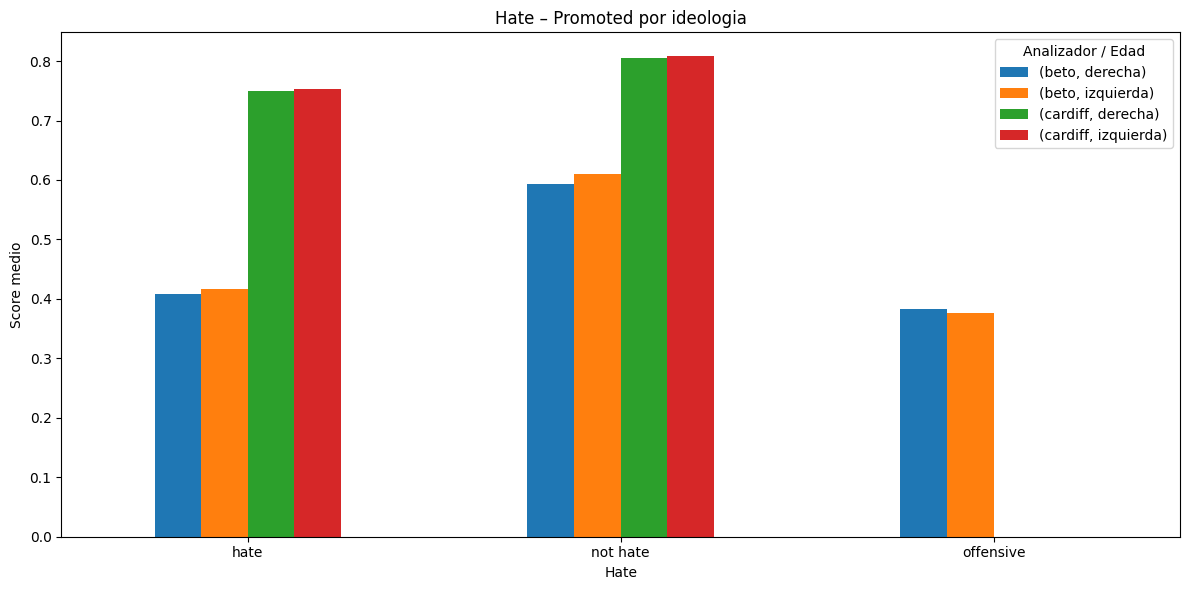

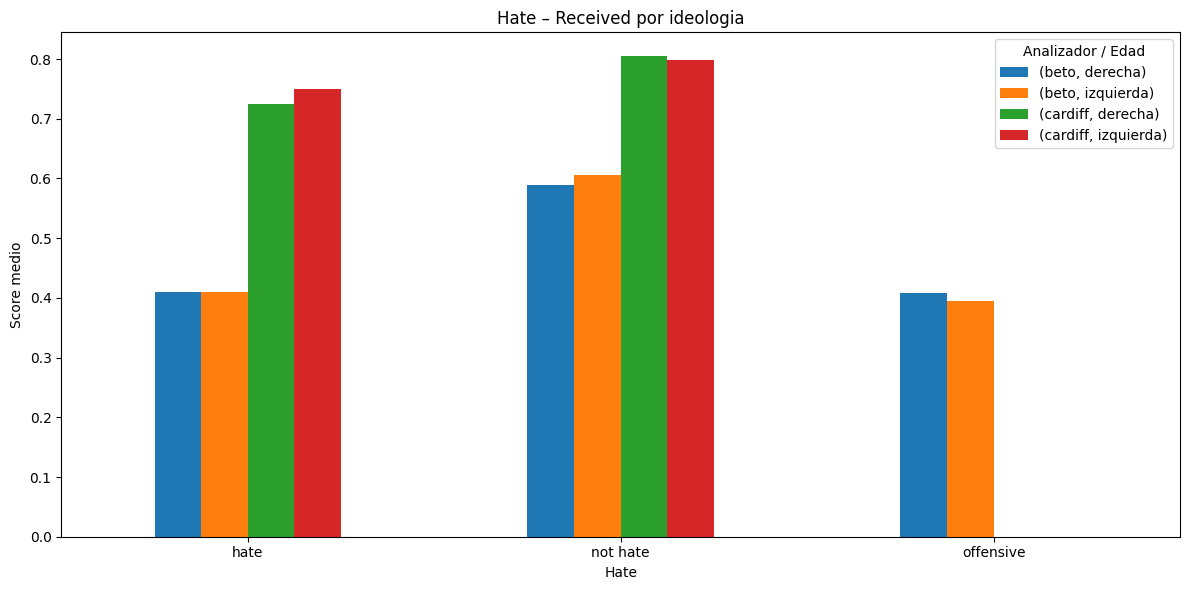

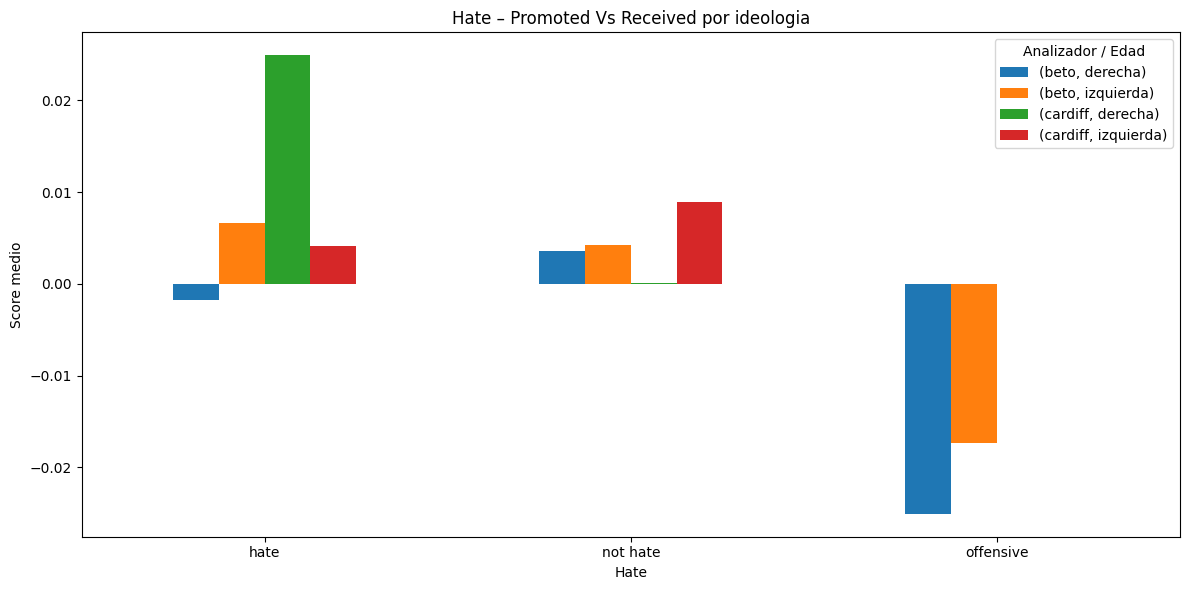

In [16]:
# -*- coding: utf-8 -*-
"""
SCRIPT GLOBAL DE ANÁLISIS DE SENTIMIENTO, EMOCIÓN Y ODIO
=======================================================
• Agrupa por **género** o **rango de edad** ("<40", "40‑60", ">60", "desconocido").
• Soporta **tweets promovidos**, **tweets recibidos (replies)** y la **comparativa
  promovido vs recibido**.
• Funciona con categorías y modelos múltiples en español o inglés:  
  «sentiment/sentimiento», «emotion/emocion», «hate/odio».
• Genera un **CSV acumulativo** y **gráficas** para cada (categoría, tipo de
  análisis).

Uso rápido
----------
```bash
python analisis_global.py  # con la configuración por defecto
```

Ajustes clave al principio del archivo:
* `RUTA_JSON`     – ruta al JSON anotado
* `CSV_SALIDA`    – CSV acumulativo
* `CATEGORIAS`    – lista de categorías a procesar (alias válidos)
* `ANALYSIS_TYPES`– ["promoted", "received", "promoted_vs_received"]
* `GROUPING`      – "gender" o "age"
"""

import json
import os
from collections import defaultdict
from typing import Any, Dict, List, Optional, Tuple

import matplotlib.pyplot as plt
import pandas as pd

# -------------------------- CONFIGURACIÓN -------------------------- #
RUTA_JSON: str = "Spain_Completo_analizado.json"
CSV_SALIDA: str = "resultados_analisis.csv"

# Categorías a procesar (puedes usar alias en español o inglés)
CATEGORIAS = ["sentiment", "emotion", "hate"]  # TODAS LAS CATEGORÍAS DISPONIBLES

# Tipos de análisis disponibles: promoted (tweets propios),
# received (replies recibidas) y promoted_vs_received (diferencia promoted‑received)
ANALYSIS_TYPES = ["promoted", "received", "promoted_vs_received"]  # INCLUIR TODO SIEMPRE  # añade "received", "promoted_vs_received" si quieres

GROUPING: str = "ideologia"  # "gender" o "age"

# ------------------------ MAPA DE ALIAS --------------------------- #
ALIAS = {
    "sentiment": "sentiment",
    "sentimiento": "sentiment",
    "emotion": "emotion",
    "emocion": "emotion",
    "hate": "hate",
    "odio": "hate",
}

# ---------------------- CONFIGURACIÓN MODELOS --------------------- #
ConfigType = Dict[str, Dict[str, Dict[str, Any]]]
CONFIG: ConfigType = {
    "sentiment": {
        "cardiff": {
            "label_path": ("analysis", "sentiment", "label"),
            "score_path": ("analysis", "sentiment", "score"),
            "classes": ["positive", "neutral", "negative"],
        },
        "stanza": {
            "label_path": ("analysis", "sentiment_stanza"),
            "score_path": None,
            "label_transform": lambda raw: {0: "negative", 1: "neutral", 2: "positive"}.get(raw),
            "classes": ["positive", "neutral", "negative"],
        },
        "beto": {
            "label_path": ("sentiment_alt_label",),
            "score_path": ("sentiment_alt_score",),
            "classes": ["positive", "neutral", "negative"],
        },
    },
    "emotion": {
        "cardiff": {
            "label_path": ("analysis", "emotions"),  # lista de dicts
            "is_list": True,
            "score_path": ("score",),
            "label_key": "label",
        },
        "t5": {
            "label_path": ("emotion_t5_label",),
            "score_path": None,  # solo label → score=1
        },
    },
    "hate": {
        "cardiff": {
            "label_path": ("analysis", "hate", "label"),
            "score_path": ("analysis", "hate", "score"),
        },
        "beto": {
            "label_path": ("hate_alt_label",),
            "score_path": ("hate_alt_score",),
            "label_transform": lambda x: "not hate" if x == "none" else x,
        },
    },
}

# ----------------------- FUNCIONES AUXILIARES ---------------------- #

def deep_get(dic: Any, path: Tuple) -> Any:
    """Acceso seguro a estructuras anidadas."""
    current = dic
    for key in path:
        if current is None:
            return None
        try:
            current = current[key]
        except (KeyError, IndexError, TypeError):
            return None
    return current


def clasificar_edad(age_value: Optional[int]) -> str:
    if age_value is None:
        return "desconocido"
    try:
        age = int(age_value)
        if age < 40:
            return "<40"
        if 40 <= age <= 60:
            return "40-60"
        return ">60"
    except Exception:
        return "desconocido"


def get_group_value(politico: Dict[str, Any]) -> str:
    if GROUPING == "gender":
        return politico.get("gender", "desconocido")
    if GROUPING == "age":
        return clasificar_edad(politico.get("age"))
    if GROUPING == "ideologia":
        return politico.get("ideologia", "desconocido")
    raise ValueError(f"Grouping no soportado: {GROUPING}")

def collect_scores(
    json_data: List[Dict[str, Any]],
    categoria: str,
    modelo: str,
    analysis_type: str,
) -> pd.DataFrame:
    """Devuelve un DataFrame con score medio por grupo/clase."""
    cfg = CONFIG[categoria][modelo]
    resultados: Dict[Tuple[str, str], List[float]] = defaultdict(list)

    for politico in json_data:
        grupo = get_group_value(politico)
        for tweet in politico.get("tweets", []):
            entradas = (
                tweet.get("replies", [])
                if analysis_type == "received"
                else [tweet]
            )
            for entrada in entradas:
                if not entrada:
                    continue

                # --- Caso lista (emotions cardiff) ---
                if cfg.get("is_list"):
                    items = deep_get(entrada, cfg["label_path"]) or []
                    for item in items:
                        label = item.get(cfg.get("label_key", "label"))
                        score = deep_get(item, cfg["score_path"]) if cfg.get("score_path") else 1.0
                        if label and score is not None:
                            resultados[(grupo, label)].append(float(score))
                    continue

                # --- Caso estándar ---
                raw_label = deep_get(entrada, cfg["label_path"])
                label = (
                    cfg.get("label_transform", lambda x: x)(raw_label)
                    if raw_label is not None
                    else None
                )

                if cfg.get("score_path") is None:
                    score = 1.0 if label is not None else None
                else:
                    raw_score = deep_get(entrada, cfg["score_path"])
                    score = (
                        cfg.get("score_transform", lambda x: x)(raw_score)
                        if raw_score is not None
                        else None
                    )

                if label is not None and score is not None:
                    resultados[(grupo, label)].append(float(score))

    filas = []
    for (grupo, label), scores in resultados.items():
        media = sum(scores) / len(scores) if scores else 0.0
        filas.append(
            {
                "analizador": modelo,
                "grupo": grupo,
                "clase": label,
                "score_medio": media,
                "tipo_analisis": analysis_type,
                "categoria": categoria,
                "agrupacion": GROUPING,
            }
        )
    return pd.DataFrame(filas)


# ---------------------------- PROGRAMA -------------------------------- #
if __name__ == "__main__":
    # --- Cargar JSON ---
    with open(RUTA_JSON, "r", encoding="utf-8") as f:
        data = json.load(f)

    df_total = pd.DataFrame()

    # --- Generar promoted / received ---
    for cat in CATEGORIAS:
        canonical = ALIAS.get(cat.lower(), cat.lower())
        if canonical not in CONFIG:
            print(f"[ADVERTENCIA] Categoría desconocida ignorada: {cat}")
            continue
        for modelo in CONFIG[canonical].keys():
            for a_type in [t for t in ANALYSIS_TYPES if t != "promoted_vs_received"]:
                df_piece = collect_scores(data, canonical, modelo, a_type)
                df_total = pd.concat([df_total, df_piece], ignore_index=True)

    # --- Comparativa promoted_vs_received ---
    if "promoted_vs_received" in ANALYSIS_TYPES:
        comp_frames = []
        for cat in set(ALIAS.get(c.lower(), c.lower()) for c in CATEGORIAS):
            if cat not in CONFIG:
                continue
            for modelo in CONFIG[cat].keys():
                df_p = df_total[
                    (df_total["categoria"] == cat)
                    & (df_total["analizador"] == modelo)
                    & (df_total["tipo_analisis"] == "promoted")
                ]
                df_r = df_total[
                    (df_total["categoria"] == cat)
                    & (df_total["analizador"] == modelo)
                    & (df_total["tipo_analisis"] == "received")
                ]
                if df_p.empty or df_r.empty:
                    continue
                merged = pd.merge(
                    df_p,
                    df_r,
                    on=["analizador", "grupo", "clase"],
                    suffixes=("_p", "_r"),
                )
                merged["score_medio"] = merged["score_medio_p"] - merged["score_medio_r"]
                merged["tipo_analisis"] = "promoted_vs_received"
                merged = merged[
                    [
                        "analizador",
                        "grupo",
                        "clase",
                        "score_medio",
                        "tipo_analisis",
                        "categoria_p",
                    ]
                ].rename(columns={"categoria_p": "categoria"})
                comp_frames.append(merged)
        if comp_frames:
            df_total = pd.concat([df_total] + comp_frames, ignore_index=True)

    # --- Guardar CSV acumulativo ---
    header = not os.path.exists(CSV_SALIDA)
    df_total.to_csv(CSV_SALIDA, mode="a", index=False, header=header)

    # --- Gráficas ---
    for cat in df_total["categoria"].unique():
        for a_type in df_total["tipo_analisis"].unique():
            df_plot = df_total[(df_total["categoria"] == cat) & (df_total["tipo_analisis"] == a_type)]
            if df_plot.empty:
                continue
            pivot = df_plot.pivot_table(
                index="clase",
                columns=["analizador", "grupo"],
                values="score_medio",
            )
            titulo = f"{cat.capitalize()} – {a_type.replace('_', ' ').title()} por {GROUPING}"
            pivot.plot(kind="bar", figsize=(12, 6), title=titulo)
            ylabel = "Score medio" if CONFIG[cat][list(CONFIG[cat].keys())[0]].get("score_path") else "Frecuencia"
            plt.ylabel(ylabel)
            plt.xlabel(cat.capitalize())
            plt.xticks(rotation=45 if cat == "emotion" else 0)
            leyenda = f"Analizador / {'Género' if GROUPING == 'gender' else 'Edad'}"
            plt.legend(title=leyenda)
            plt.tight_layout()
            nombre_archivo = f"grafica_{cat}_{a_type}_{GROUPING}.png"
            plt.savefig(nombre_archivo, dpi=300)
            plt.show()



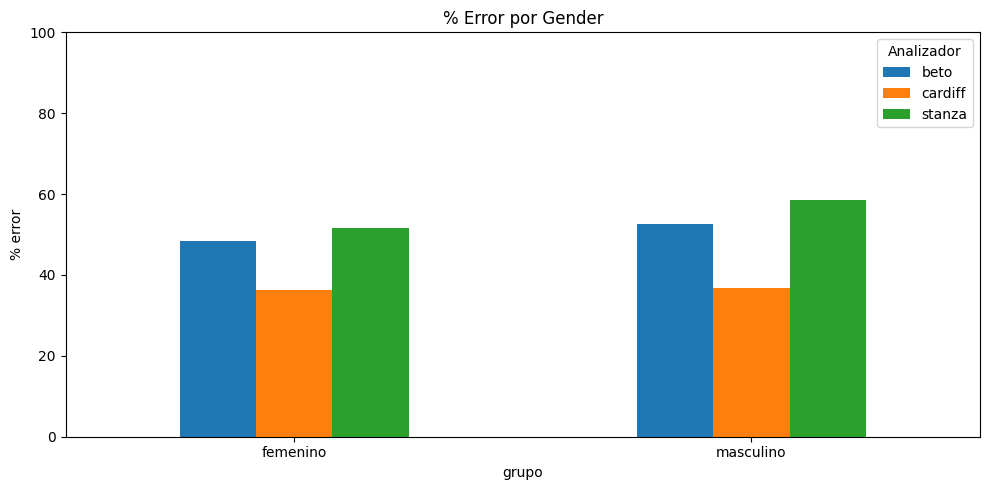

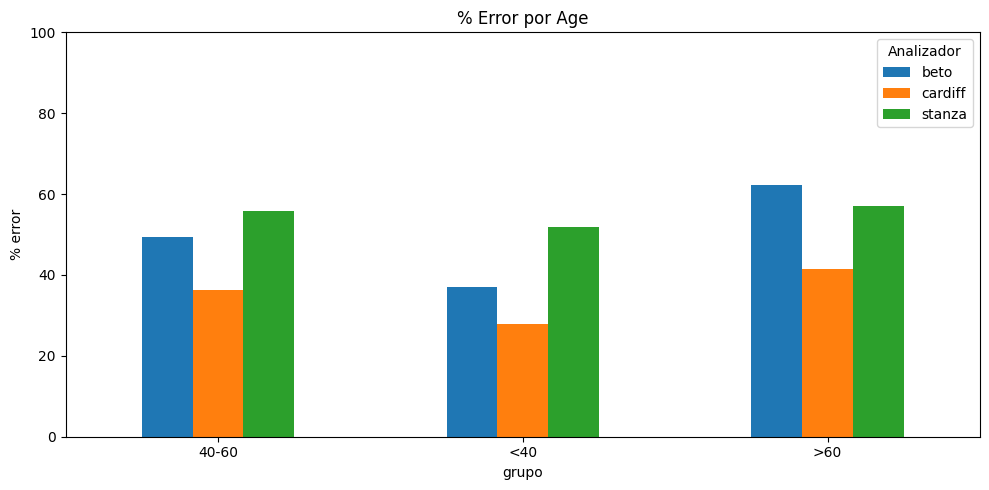

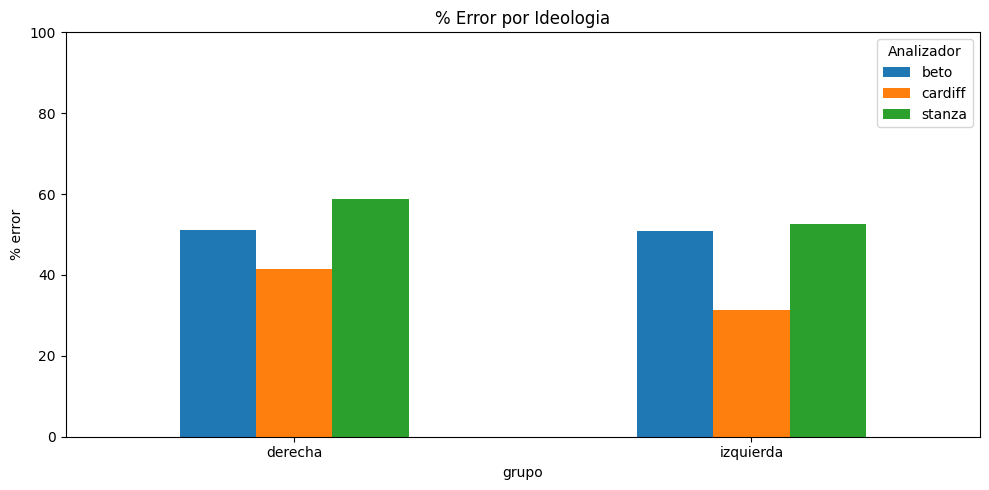

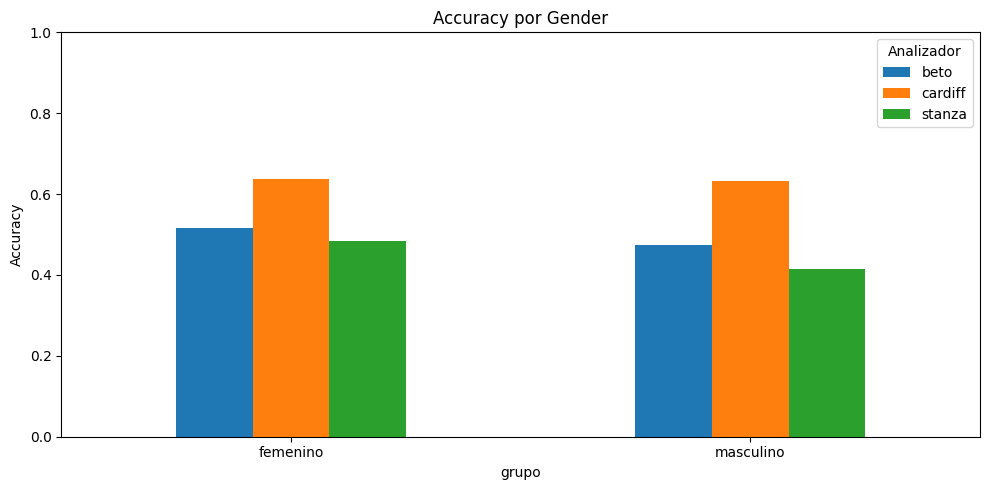

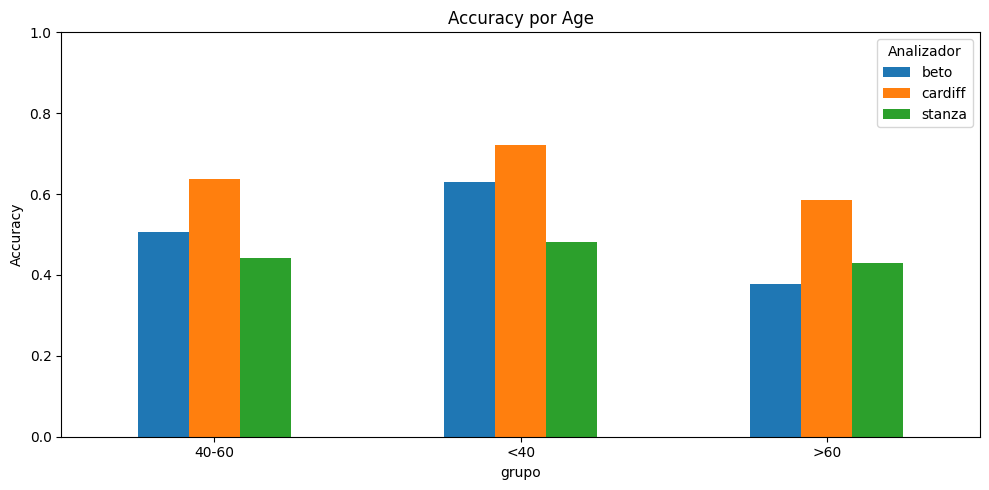

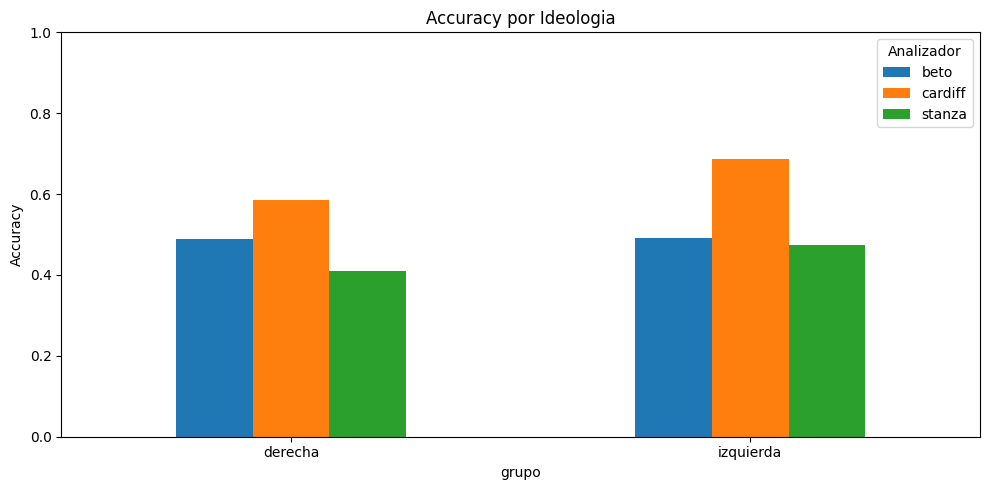

In [11]:
# -*- coding: utf-8 -*-
"""
EVALUACIÓN DE ERRORES Y ACCURACY POR GRUPO
==========================================
Este script combina dos análisis clásicos para evaluar los modelos de
clasificación de sentimiento:

1. **Porcentaje de error** (predicción ≠ etiqueta oro) por grupo demográfico
   (género, rango de edad, ideología).
2. **Accuracy** (predicción = etiqueta oro) por grupo.

Produce tanto **tablas** en `pandas` como **gráficas** comparativas.

Uso rápido
----------
```bash
python evaluacion_error_accuracy.py
```

Ajustes importantes al principio del archivo:
* `RUTA_JSON`  – ruta al JSON anotado.
* `ATRIBUTOS`  – lista de atributos a analizar (`gender`, `age`, `ideologia`).
* `ANALIZADORES` – lista de modelos a evaluar.
* `MODO_GRAFICO` – `True` para mostrar gráficos, `False` solo CSV/console.

Los resultados se guardan en un CSV (*append*) llamado
`evaluacion_errores_accuracy.csv`.
"""

import json
import os
from typing import Dict, List, Tuple

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score

# -------------------- CONFIGURACIÓN DEL USUARIO -------------------- #
RUTA_JSON: str = "Spain_Completo_analizado.json"
CSV_SALIDA: str = "evaluacion_errores_accuracy.csv"
ATRIBUTOS: List[str] = ["gender", "age", "ideologia"]  # atributos a analizar
ANALIZADORES: List[str] = ["cardiff", "stanza", "beto"]   # modelos
MODO_GRAFICO: bool = True

# ------------------------ MAPAS AUXILIARES ------------------------ #
MAPA_TOTAL = {-1: "negative", 0: "neutral", 1: "positive"}
STANZA_MAP = {0: "negative", 1: "neutral", 2: "positive"}


def clasificar_edad(age_val) -> str:
    try:
        age = int(age_val)
        if age < 40:
            return "<40"
        if age <= 60:
            return "40-60"
        return ">60"
    except Exception:
        return "desconocido"


def extraer_preds(tweet: Dict) -> Dict[str, str]:
    """Devuelve dict {analizador: pred} para el tweet dado."""
    analysis = tweet.get("analysis", {})
    preds = {
        "cardiff": analysis.get("sentiment", {}).get("label"),
        "stanza": STANZA_MAP.get(analysis.get("sentiment_stanza")),
        "beto": tweet.get("sentiment_alt_label"),
    }
    return preds


# ---------------------- PROCESAMIENTO PRINCIPAL --------------------- #

with open(RUTA_JSON, "r", encoding="utf-8") as f:
    data = json.load(f)

rows_error: List[Dict] = []
rows_acc: List[Dict] = []

for politico in data:
    grupos: Dict[str, str] = {
        "gender": politico.get("gender", "desconocido"),
        "age": clasificar_edad(politico.get("age")),
        "ideologia": politico.get("ideologia", "desconocido"),
    }

    for tweet in politico.get("tweets", []):
        gold_raw = tweet.get("annotations", {}).get("Total")
        if gold_raw not in MAPA_TOTAL:
            continue
        gold = MAPA_TOTAL[gold_raw]
        preds = extraer_preds(tweet)

        for atr in ATRIBUTOS:
            grupo_val = grupos[atr]
            for analizador in ANALIZADORES:
                pred = preds.get(analizador)
                # Totales para porcentaje de error
                rows_error.append(
                    {
                        "atributo": atr,
                        "grupo": grupo_val,
                        "analizador": analizador,
                        "error": int(pred != gold) if pred else None,
                    }
                )
                # Datos para accuracy (se filtran NaN más tarde)
                rows_acc.append(
                    {
                        "atributo": atr,
                        "grupo": grupo_val,
                        "analizador": analizador,
                        "gold": gold,
                        "pred": pred,
                    }
                )

# -------------------- CÁLCULO PORCENTAJE DE ERROR ------------------- #

df_err = pd.DataFrame(rows_error).dropna(subset=["error"])

df_pct_error = (
    df_err.groupby(["atributo", "grupo", "analizador"])["error"].mean() * 100
).reset_index().rename(columns={"error": "pct_error"})

# ----------------------- CÁLCULO ACCURACY -------------------------- #

df_acc_raw = pd.DataFrame(rows_acc).dropna(subset=["pred"])
accuracies = []
for (atr, grupo, analizador), df_grp in df_acc_raw.groupby(["atributo", "grupo", "analizador"]):
    acc = accuracy_score(df_grp["gold"], df_grp["pred"])
    accuracies.append({"atributo": atr, "grupo": grupo, "analizador": analizador, "accuracy": acc})

df_accuracy = pd.DataFrame(accuracies)

# -------------------- GUARDAR CSV ACUMULATIVO ---------------------- #
result_combined = pd.concat([df_pct_error, df_accuracy], axis=0, ignore_index=True, sort=False)
result_combined["metrica"] = result_combined.apply(lambda r: "pct_error" if pd.notna(r.get("pct_error")) else "accuracy", axis=1)

header = not os.path.exists(CSV_SALIDA)
result_combined.to_csv(CSV_SALIDA, mode="a", index=False, header=header)

# ------------------------- VISUALIZACIÓN --------------------------- #
if MODO_GRAFICO:
    # Porcentaje de error
    for atr in ATRIBUTOS:
        df_plot = df_pct_error[df_pct_error["atributo"] == atr]
        if df_plot.empty:
            continue
        pivot = df_plot.pivot(index="grupo", columns="analizador", values="pct_error")
        pivot.plot(kind="bar", figsize=(10, 5), title=f"% Error por {atr.capitalize()}")
        plt.ylabel("% error")
        plt.ylim(0, 100)
        plt.xticks(rotation=0)
        plt.legend(title="Analizador")
        plt.tight_layout()
        nombre_archivo = f"grafica_{cat}_{a_type}_{GROUPING}.png"
        plt.savefig(nombre_archivo, dpi=300)
        plt.show()

    # Accuracy
    for atr in ATRIBUTOS:
        df_plot = df_accuracy[df_accuracy["atributo"] == atr]
        if df_plot.empty:
            continue
        pivot = df_plot.pivot(index="grupo", columns="analizador", values="accuracy")
        pivot.plot(kind="bar", figsize=(10, 5), title=f"Accuracy por {atr.capitalize()}")
        plt.ylabel("Accuracy")
        plt.ylim(0, 1)
        plt.xticks(rotation=0)
        plt.legend(title="Analizador")
        plt.tight_layout()
        nombre_archivo = f"grafica_{cat}_{a_type}_{GROUPING}.png"
        plt.savefig(nombre_archivo, dpi=300)
        plt.show()
